In [1]:
# =============================================================================
# Cell 1: Setup and Imports
# =============================================================================
import pandas as pd
import numpy as np
import re
import nltk
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    precision_recall_curve
)
from scipy.sparse import hstack
import xgboost as xgb
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping

print("\n--- Cell 1: Setup and all imports complete ---")


--- Cell 1: Setup and all imports complete ---


In [2]:
# =============================================================================
# Cell 2: Data Loading and Preprocessing
# =============================================================================

# Create necessary directories
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('results/charts', exist_ok=True)

# Load Dataset
df = pd.read_csv('loan.csv', low_memory=False)

# Define target and clean up dataset
df['is_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['text_data'] = df['title'].fillna('') + ' ' + df['desc'].fillna('')
df['text_data'] = df['text_data'].str.strip()
df.loc[df['text_data'] == '', 'text_data'] = np.nan
df.dropna(subset=['text_data'], inplace=True)

try:
    stopwords = nltk.corpus.stopwords.words('english')
except LookupError:
    print("Downloading NLTK stopwords...")
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words('english')

def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = [word for word in text.split() if word not in stopwords]
    return ' '.join(words)
    
df['text_data'] = df['text_data'].apply(preprocess_text)

# Choose fields
structured_numeric_features = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti',
    'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'delinq_2yrs',
    'inq_last_6mths', 'pub_rec', 'collections_12_mths_ex_med'
]
structured_categorical_features = [
    'term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
    'verification_status', 'purpose', 'addr_state'
]

text_feature = 'text_data'

target = 'is_default'

# Fill missing structured data
for col in structured_numeric_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].median())
for col in structured_categorical_features:
    df[col] = df[col].fillna(df[col].mode()[0])

# Set up model for Cross Validation
X = df[structured_numeric_features + structured_categorical_features + [text_feature]]
y = df[target]


X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dataset Size: {len(df)}, Training set size: {len(X_train_full)}, Final test set size: {len(X_test_final)}")
print("\n--- Cell 2: Data Loading and Preprocessing complete ---")

Dataset Size: 252964, Training set size: 202371, Final test set size: 50593

--- Cell 2: Data Loading and Preprocessing complete ---



--- Figure 1: Correlation Heatmap of Numeric Features ---


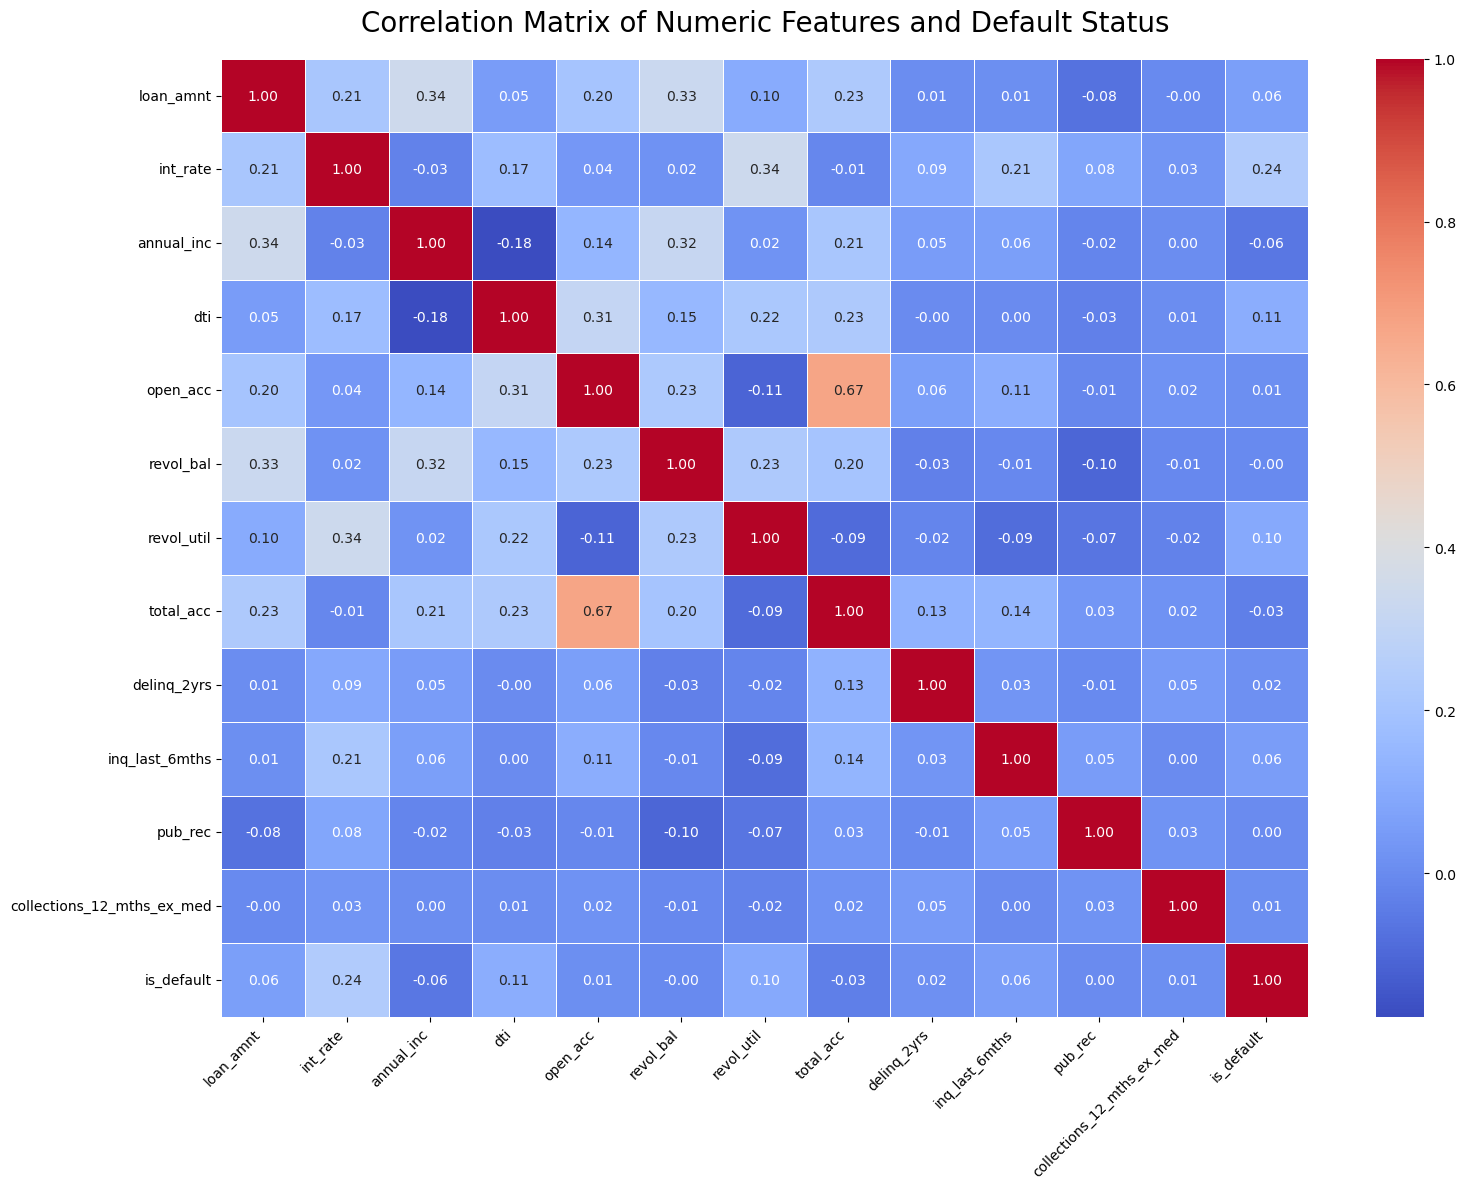


--- Table 2: Descriptive Statistics for Key Numeric Features ---
           loan_amnt       int_rate    installment    annual_inc            dti
count  252964.000000  252964.000000  252964.000000  2.529640e+05  252964.000000
mean    13562.984456      13.764627     418.118326  7.253849e+04      16.544232
std      8131.723920       4.401963     244.933079  5.881240e+04       7.788680
min       500.000000       5.320000      15.690000  3.000000e+03       0.000000
25%      7200.000000      10.740000     239.550000  4.500000e+04      10.750000
50%     12000.000000      13.530000     365.230000  6.200000e+04      16.200000
75%     18250.000000      16.550000     547.550000  8.700000e+04      21.990000
max     35000.000000      28.990000    1424.570000  8.706582e+06      57.140000

--- Figure 2: Histogram of Loan Amount ---


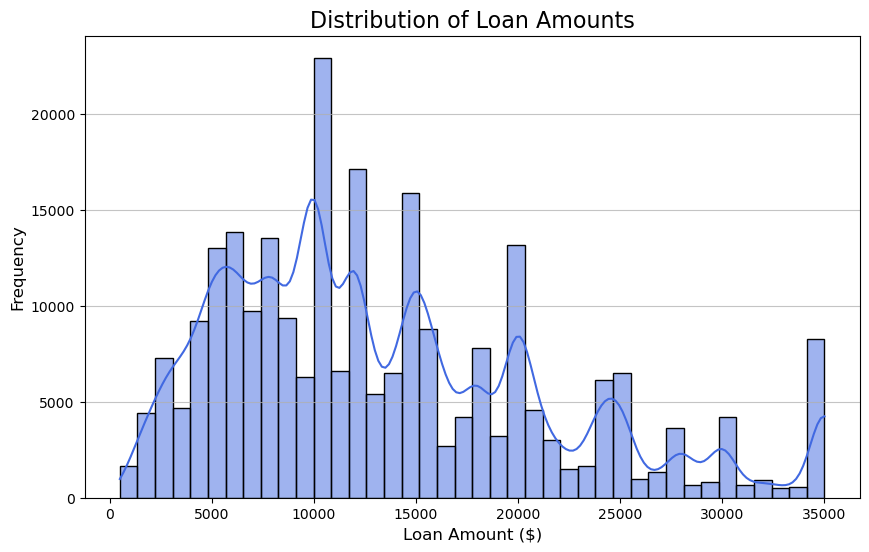


--- Table 3: Frequency Counts for Key Categorical Features ---

--- Purpose ---
purpose
debt_consolidation    148361
credit_card            50076
home_improvement       14929
other                  14276
major_purchase          6264
small_business          4745
car                     3646
medical                 2854
moving                  2028
wedding                 1955
house                   1652
vacation                1588
educational              323
renewable_energy         267

--- Grade ---
grade
A    42296
B    76061
C    65319
D    40504
E    19186
F     7660
G     1938

--- Figure 3: Box Plot of Interest Rate by Grade ---


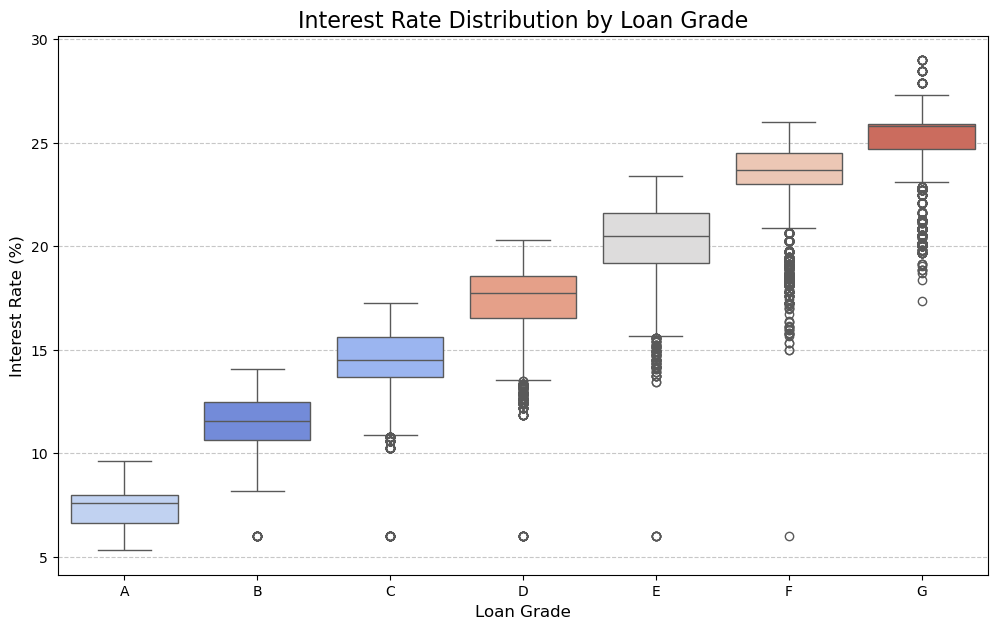


--- Figure 4: Class Imbalance Pie Chart ---


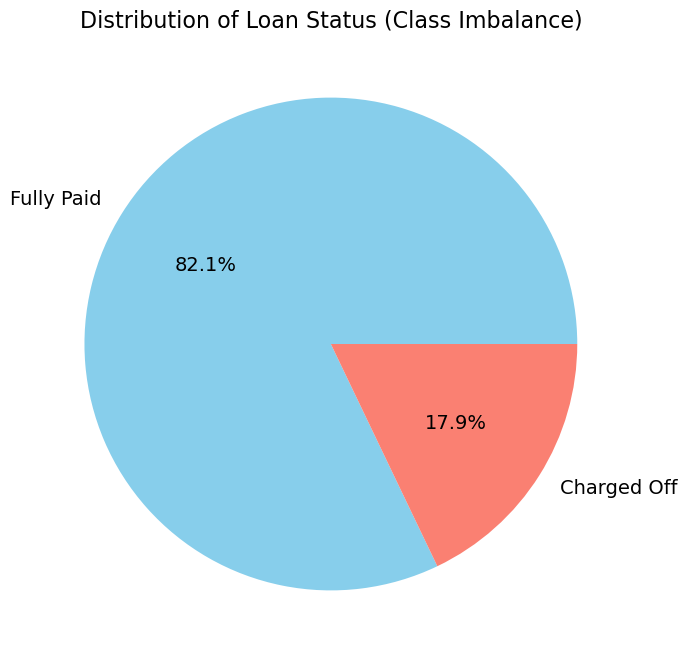


--- Figure 5: Word Cloud ---


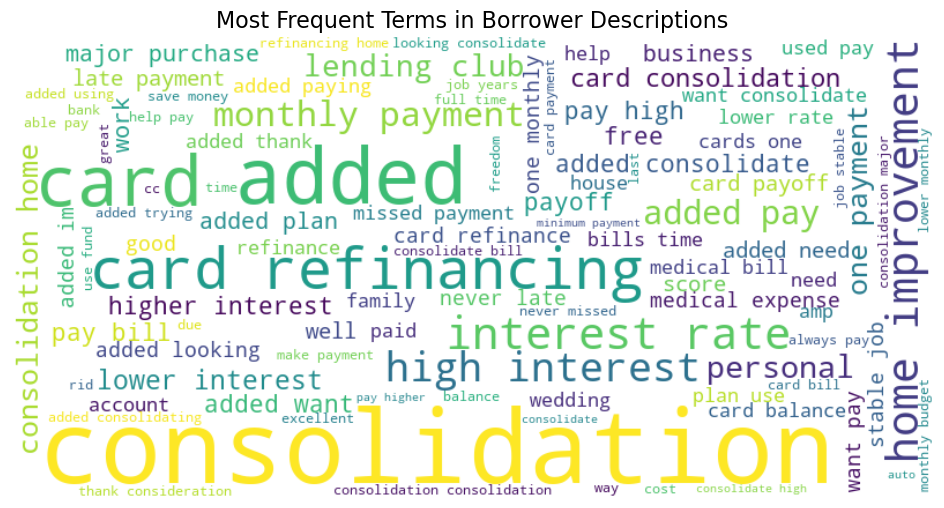


--- Cell 3: Data Presentation complete ---


In [3]:
# =============================================================================
# Cell 3: Data Presentation
# =============================================================================

# Figure 1: Correlation Heatmap of Numeric Features
print("\n--- Figure 1: Correlation Heatmap of Numeric Features ---")
corr_df = X_train_full[structured_numeric_features].join(y_train_full)
correlation_matrix = corr_df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Numeric Features and Default Status', fontsize=20, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('results/charts/Figure1.png')
plt.show()



# Table 3: Descriptive Statistics for Key Numeric Features
print("\n--- Table 3: Descriptive Statistics for Key Numeric Features ---")
numeric_cols_to_describe = [
    'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti']
print(df[numeric_cols_to_describe].describe().to_string())



# Figure 2: Histogram of Loan Amount
print("\n--- Figure 2: Histogram of Loan Amount ---")
plt.figure(figsize=(10, 6))
sns.histplot(df['loan_amnt'], bins=40, kde=True, color='royalblue')
plt.title('Distribution of Loan Amounts', fontsize=16)
plt.xlabel('Loan Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.savefig('results/charts/Figure2.png')
plt.show()



# Table 4: Frequency Counts for Key Categorical Features
print("\n--- Table 4: Frequency Counts for Key Categorical Features ---")
print("\n--- Purpose ---")
print(df['purpose'].value_counts().to_string())
print("\n--- Grade ---")
print(df['grade'].value_counts().sort_index().to_string())



# Figure 3: Box Plot of Interest Rate by Grade
print("\n--- Figure 3: Box Plot of Interest Rate by Grade ---")
grade_order = sorted(df['grade'].unique())
plt.figure(figsize=(12, 7))
sns.boxplot(x='grade', y='int_rate', data=df, order=grade_order, palette='coolwarm', hue='grade', legend=False)
plt.title('Interest Rate Distribution by Loan Grade', fontsize=16)
plt.xlabel('Loan Grade', fontsize=12)
plt.ylabel('Interest Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('results/charts/Figure3.png')
plt.show()



# Figure 4: Class Imbalance Pie Chart
print("\n--- Figure 4: Class Imbalance Pie Chart ---")
plt.figure(figsize=(8, 8))
df['loan_status'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],
    textprops={'fontsize': 14}
)
plt.title('Distribution of Loan Status (Class Imbalance)', fontsize=16)
plt.ylabel('')
plt.savefig('results/charts/Figure4.png')
plt.show()



# Figure 5: Word Cloud
print("\n--- Figure 5: Word Cloud ---")
text = " ".join(review for review in df["text_data"].astype(str))
stopwords = set(STOPWORDS)
stopwords.update(["loan", "borrower", "lender", "credit", "debt", "month", "year", "br"])

wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
    max_words=100,
    width=800,
    height=400
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Terms in Borrower Descriptions", fontsize=16)
plt.savefig('results/charts/Figure5.png')
plt.show()

print("\n--- Cell 3: Data Presentation complete ---")

In [4]:
# =============================================================================
# Cell 4: BERT Preprocessing
# =============================================================================

# Define the structure of our preprocessors
structured_numeric_features = X_train_full.select_dtypes(include=np.number).columns.tolist()
structured_categorical_features = X_train_full.select_dtypes(include='object').drop('text_data', axis=1).columns.tolist()

preprocessor_structured = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), structured_numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), structured_categorical_features)
    ],
    remainder='drop'
)

# Pre compute BERT embeddings
print("Pre-computing BERT embeddings for the entire training set.")
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_full_bert_text = bert_model.encode(X_train_full['text_data'].tolist(), show_progress_bar=True, device='cpu')

print("\n--- Cell 4: BERT Preprocessing complete ---")

Pre-computing BERT embeddings for the entire training set.


Batches:   0%|          | 0/6325 [00:00<?, ?it/s]


--- Cell 4: BERT Preprocessing complete ---


In [5]:
# =============================================================================
# Cell 5: Model and Cross-Validation Setup
# =============================================================================

# CV Setup
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
all_cv_results = {}

# Models to train
models_to_train = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, n_jobs=1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'MLP': 'custom_mlp',
    'LSTM_Hybrid': 'custom_lstm',
    'TabNet': TabNetClassifier(optimizer_params=dict(lr=2e-2), verbose=0)
}

# Custom Neural Network Builders
def build_mlp(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

def build_lstm_hybrid(struct_shape, text_shape):
    struct_input = Input(shape=struct_shape, name='structured_input')
    struct_model = Dense(32, activation='relu')(struct_input)
    text_input = Input(shape=text_shape, name='text_input')
    text_model = LSTM(64, dropout=0.3)(text_input)
    combined = concatenate([struct_model, text_model])
    final_model = Dense(32, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(final_model)
    model = Model(inputs=[struct_input, text_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

print("\n--- Cell 5: Model and Cross-Validation Setup complete ---")


--- Cell 5: Model and Cross-Validation Setup complete ---


In [6]:
# =============================================================================
# Cell 6: Model Training
# =============================================================================

warnings.filterwarnings('ignore', message='Best weights from best epoch are automatically used!')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\n{'='*20} FOLD {fold+1}/{N_SPLITS} {'='*20}")

    X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

    print("Part 1: Performing feature engineering for the current fold...")
    X_train_struct_processed = preprocessor_structured.fit_transform(X_train)
    X_val_struct_processed = preprocessor_structured.transform(X_val)
    
    preprocessor_tfidf_fold = ColumnTransformer(transformers=[('num', StandardScaler(), structured_numeric_features),('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), structured_categorical_features),('tfidf', TfidfVectorizer(max_features=1000), 'text_data')], remainder='drop')
    X_train_tfidf = preprocessor_tfidf_fold.fit_transform(X_train)
    X_val_tfidf = preprocessor_tfidf_fold.transform(X_val)

    def document_vector(doc, model):
        doc_words = [word for word in doc.split() if word in model.wv.index_to_key]
        if not doc_words: return np.zeros(model.vector_size)
        return np.mean(model.wv[doc_words], axis=0)

    tokenized_text_train = [text.split() for text in X_train['text_data']]
    w2v_model = Word2Vec(sentences=tokenized_text_train, vector_size=100, window=5, min_count=2, workers=4)
    X_train_w2v_text = np.array([document_vector(text, w2v_model) for text in X_train['text_data']])
    X_val_w2v_text = np.array([document_vector(text, w2v_model) for text in X_val['text_data']])
    X_train_w2v = np.hstack([X_train_struct_processed, X_train_w2v_text])
    X_val_w2v = np.hstack([X_val_struct_processed, X_val_w2v_text])
    
    X_train_bert_text = X_train_full_bert_text[train_idx]
    X_val_bert_text = X_train_full_bert_text[val_idx]
    X_train_bert = np.hstack([X_train_struct_processed, X_train_bert_text])
    X_val_bert = np.hstack([X_val_struct_processed, X_val_bert_text])

    feature_sets = {
        'structured_only': (X_train_struct_processed, X_val_struct_processed),
        'tfidf': (X_train_tfidf, X_val_tfidf), 
        'w2v': (X_train_w2v, X_val_w2v), 
        'bert': (X_train_bert, X_val_bert)
    }
    
    print("Part 2: Training all models...")
    for model_name, model_obj in models_to_train.items():
        for fs_name, (X_train_fs, X_val_fs) in feature_sets.items():
            if model_name == 'LSTM_Hybrid' and fs_name != 'w2v': continue
            if fs_name == 'structured_only' and model_name == 'LSTM_Hybrid': continue
            
            result_key = f"{model_name}_{fs_name}" if model_name != 'LSTM_Hybrid' else "LSTM_Hybrid"
            if fold == 0: all_cv_results[result_key] = []
            
            print(f"  - Training {result_key}...")            
            if model_name in ['LogisticRegression', 'XGBoost']:
                model_obj.fit(X_train_fs, y_train)
                y_pred_proba = model_obj.predict_proba(X_val_fs)[:, 1]
            elif model_name == 'MLP':
                mlp_model = build_mlp((X_train_fs.shape[1],))
                mlp_model.fit(X_train_fs, y_train, epochs=30, batch_size=256, verbose=0,
                              validation_data=(X_val_fs, y_val),
                              callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
                y_pred_proba = mlp_model.predict(X_val_fs, verbose=0).flatten()
            elif model_name == 'LSTM_Hybrid':
                X_train_text_reshaped = X_train_fs[:, X_train_struct_processed.shape[1]:].reshape(X_train_fs.shape[0], 1, 100)
                X_val_text_reshaped = X_val_fs[:, X_val_struct_processed.shape[1]:].reshape(X_val_fs.shape[0], 1, 100)
                lstm_model = build_lstm_hybrid(X_train_struct_processed.shape[1:], X_train_text_reshaped.shape[1:])
                lstm_model.fit(
                    [X_train_struct_processed, X_train_text_reshaped], y_train,
                    validation_data=([X_val_struct_processed, X_val_text_reshaped], y_val),
                    epochs=30, batch_size=256, verbose=0,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
                )
                y_pred_proba = lstm_model.predict([X_val_struct_processed, X_val_text_reshaped], verbose=0).flatten()
            elif model_name == 'TabNet':
                X_train_dense = X_train_fs.toarray() if hasattr(X_train_fs, 'toarray') else X_train_fs
                X_val_dense = X_val_fs.toarray() if hasattr(X_val_fs, 'toarray') else X_val_fs
                model_obj.fit(
                    X_train_dense, y_train,
                    eval_set=[(X_val_dense, y_val)],
                    patience=10, max_epochs=100,
                    eval_metric=['auc']
                )
                y_pred_proba = model_obj.predict_proba(X_val_dense)[:, 1]

            all_cv_results[result_key].append({'y_true': y_val, 'y_pred_proba': y_pred_proba})

print("\n--- Cell 6: Model Training complete ---")


==================== FOLD 1/5 ====================
Part 1: Performing feature engineering for the current fold...
Part 2: Training all models...
  - Training LogisticRegression_structured_only...
  - Training LogisticRegression_tfidf...
  - Training LogisticRegression_w2v...
  - Training LogisticRegression_bert...
  - Training XGBoost_structured_only...
  - Training XGBoost_tfidf...
  - Training XGBoost_w2v...
  - Training XGBoost_bert...
  - Training MLP_structured_only...
  - Training MLP_tfidf...
  - Training MLP_w2v...
  - Training MLP_bert...
  - Training LSTM_Hybrid...
  - Training TabNet_structured_only...

Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_auc = 0.70447
  - Training TabNet_tfidf...

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_auc = 0.7035
  - Training TabNet_w2v...

Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_auc = 0.70688
  - Training TabNet_bert...

Early stopping occurred at epoch 

In [7]:
# =============================================================================
# Cell 7: Analyze Main Results
# =============================================================================

OPTIMAL_THRESHOLD = 0.2 

summary_data = []
for model_name, fold_results in all_cv_results.items():
    fold_f1s, fold_auprcs, fold_recalls, fold_precisions = [], [], [], []
    
    if not fold_results: continue

    for result in fold_results:
        y_true = result['y_true']
        y_pred_proba = result['y_pred_proba']
        
        y_pred_class = (y_pred_proba >= OPTIMAL_THRESHOLD).astype(int)
        
        fold_f1s.append(f1_score(y_true, y_pred_class))
        fold_auprcs.append(average_precision_score(y_true, y_pred_proba))
        fold_recalls.append(recall_score(y_true, y_pred_class, zero_division=0))
        fold_precisions.append(precision_score(y_true, y_pred_class, zero_division=0))

    summary_data.append({
        'Model': model_name,
        'Mean F1-Score': np.mean(fold_f1s),
        'F1 Std Dev': np.std(fold_f1s),
        'Mean AUPRC': np.mean(fold_auprcs),
        'Mean Recall': np.mean(fold_recalls),
        'Mean Precision': np.mean(fold_precisions)
    })

cv_summary_df = pd.DataFrame(summary_data).set_index('Model').sort_values(by='Mean F1-Score', ascending=False)
print(f"\n--- CV PERFORMANCE SUMMARY (at {OPTIMAL_THRESHOLD} Threshold) ---")
print(cv_summary_df)

cv_summary_df.to_csv('results/threshold.csv')

best_model_name = cv_summary_df.index[0]
print(f"\nBest model based on Mean F1-Score is: {best_model_name}")

print("\n--- Cell 7: Analyze Main Results complete ---")


--- CV PERFORMANCE SUMMARY (at 0.2 Threshold) ---
                                    Mean F1-Score  F1 Std Dev  Mean AUPRC  \
Model                                                                       
MLP_bert                                 0.407371    0.001591    0.347452   
MLP_tfidf                                0.406985    0.001784    0.346340   
LSTM_Hybrid                              0.405703    0.002354    0.344356   
XGBoost_tfidf                            0.403150    0.002810    0.338367   
MLP_structured_only                      0.403130    0.002146    0.342512   
MLP_w2v                                  0.402763    0.002595    0.344289   
TabNet_w2v                               0.402241    0.002925    0.338950   
LogisticRegression_bert                  0.402239    0.003802    0.339027   
TabNet_structured_only                   0.402144    0.001581    0.336336   
XGBoost_structured_only                  0.401725    0.003704    0.336892   
LogisticRegression_w2v   


--- Figure 6: F1-Score and AUPRC Uplift from Unstructured Data ---


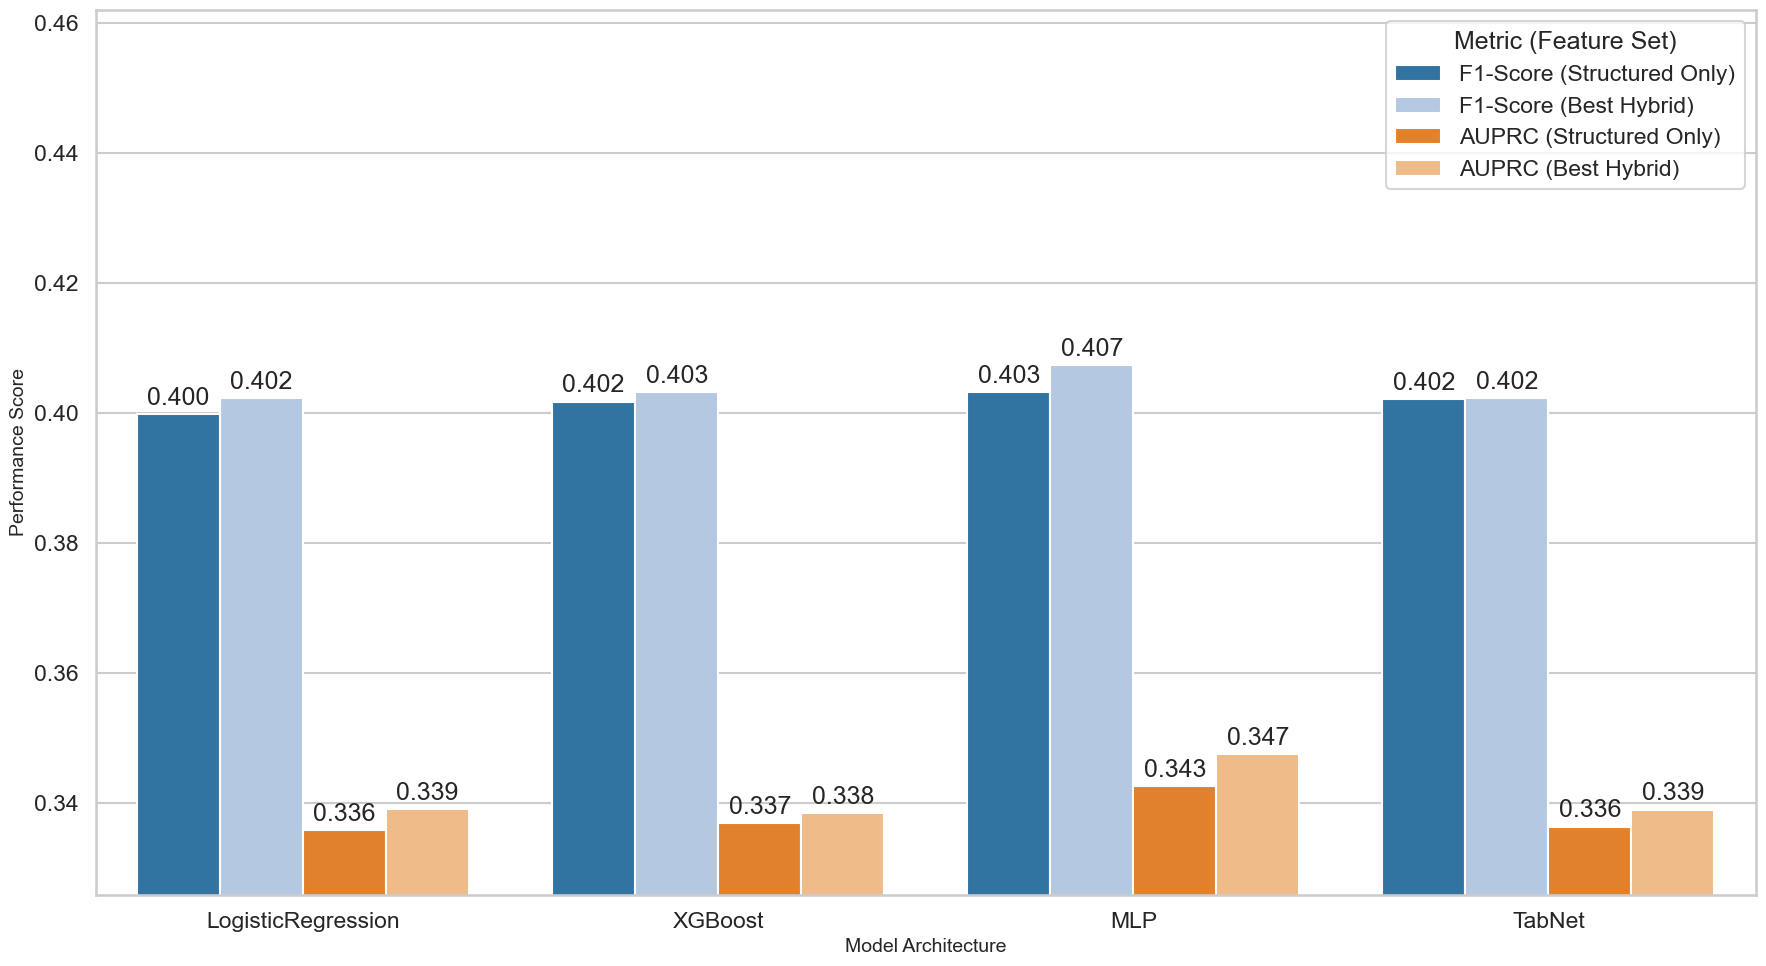


--- Figure 7: Percentage Uplift in Performance ---


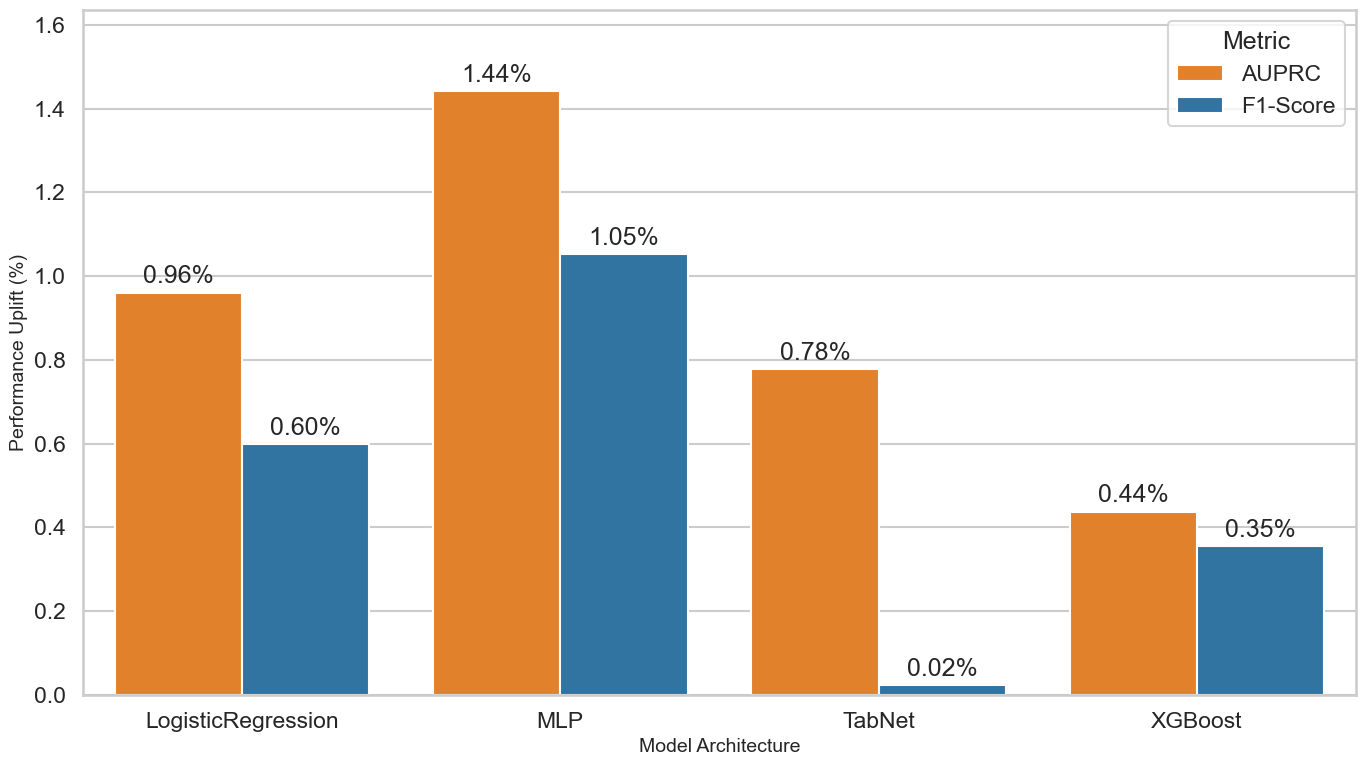


--- Figure 8: Model Stability (Grouped Boxplot) ---


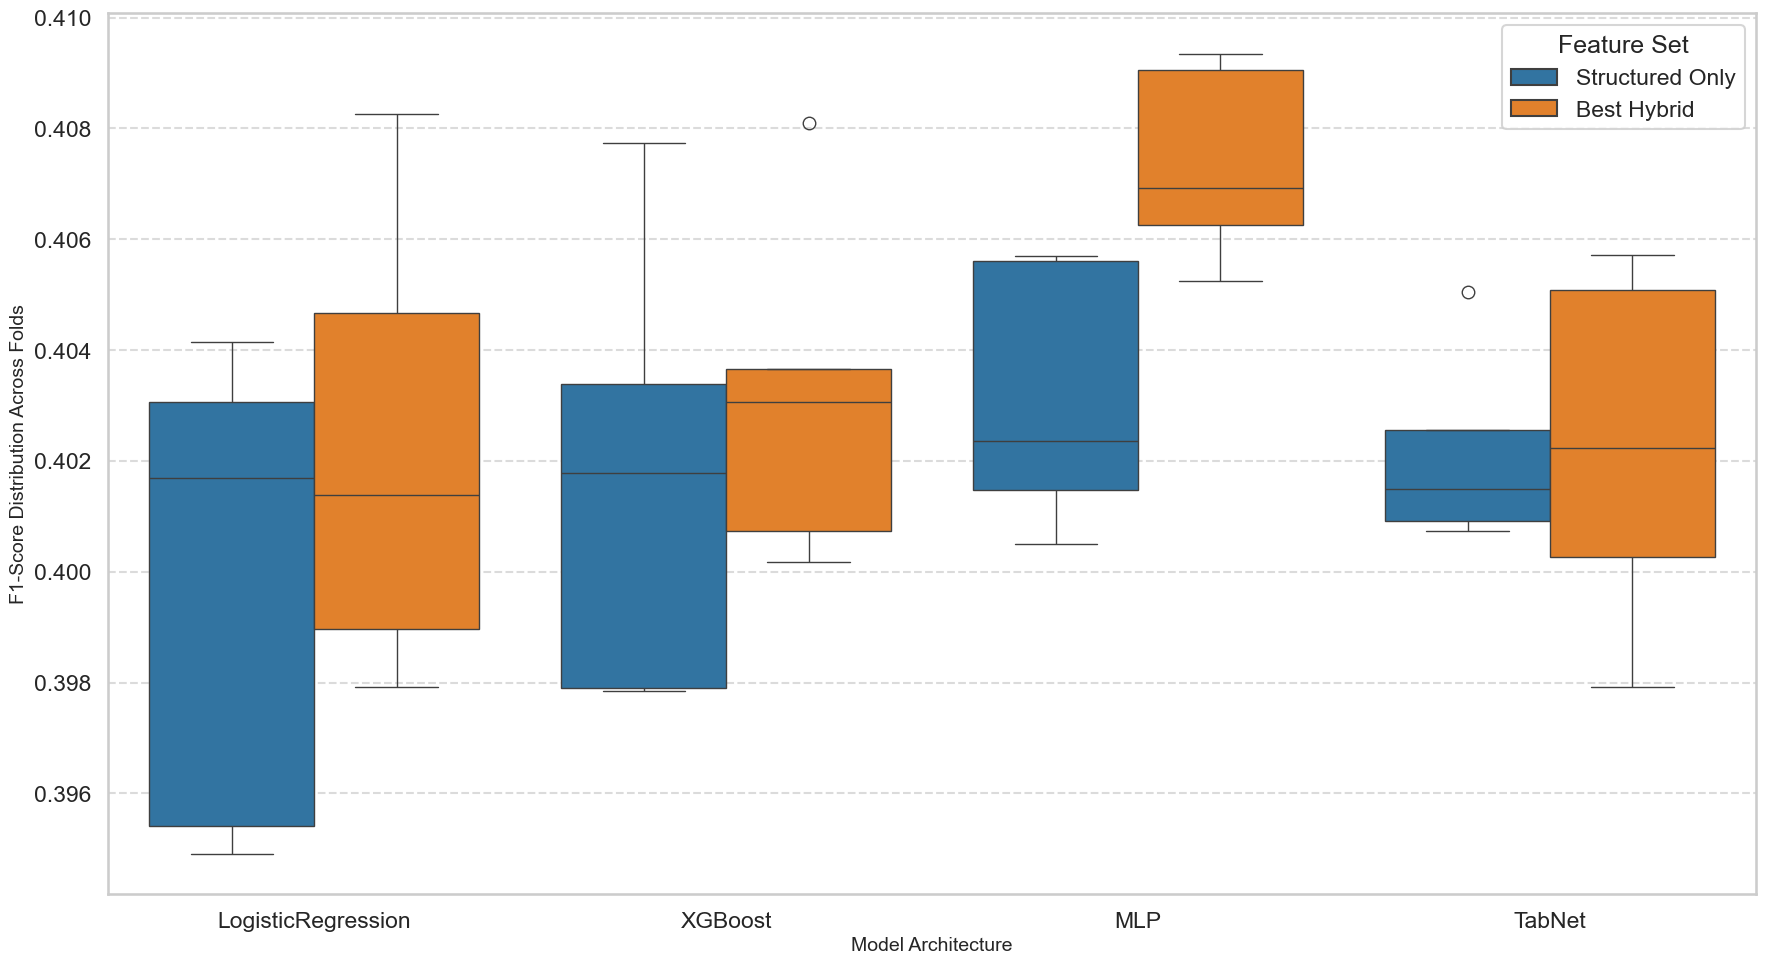


--- Figure 9: Performance Trajectory Across Feature Sets ---


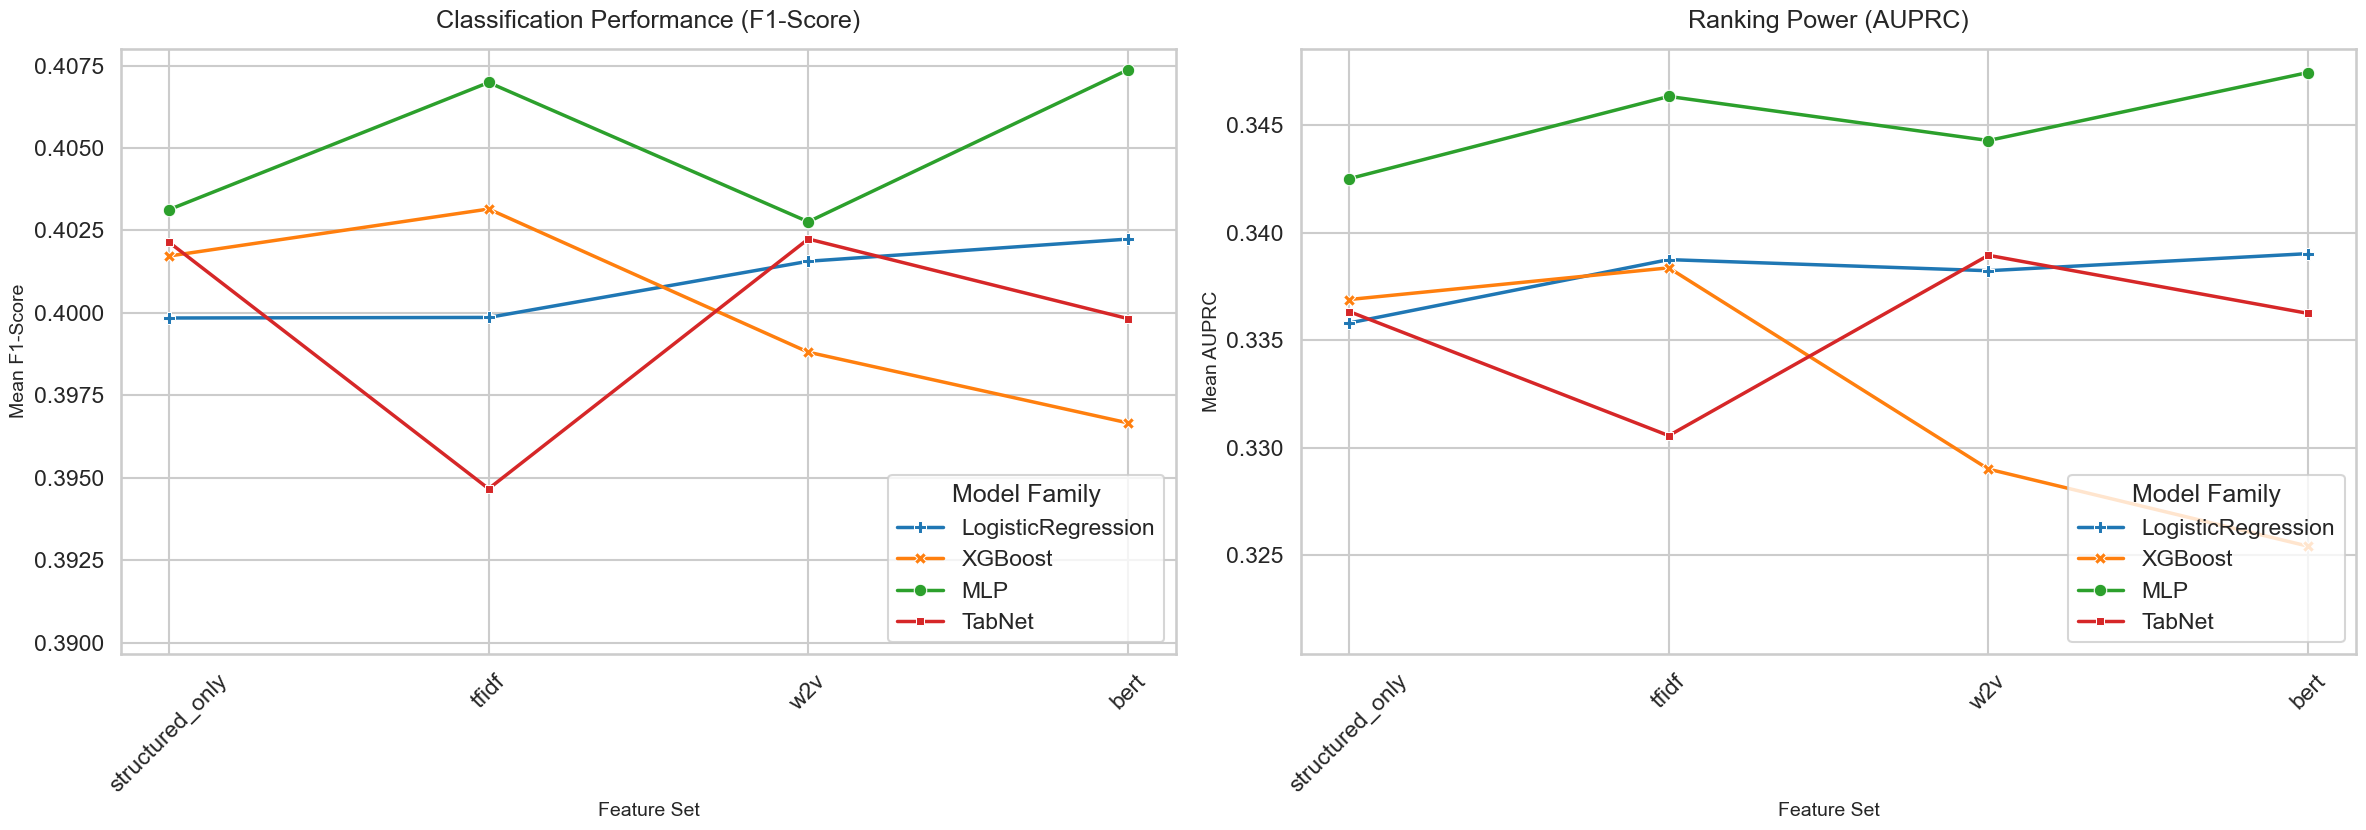


--- Figure 10: Precision vs. Recall Trade-off for All Models ---


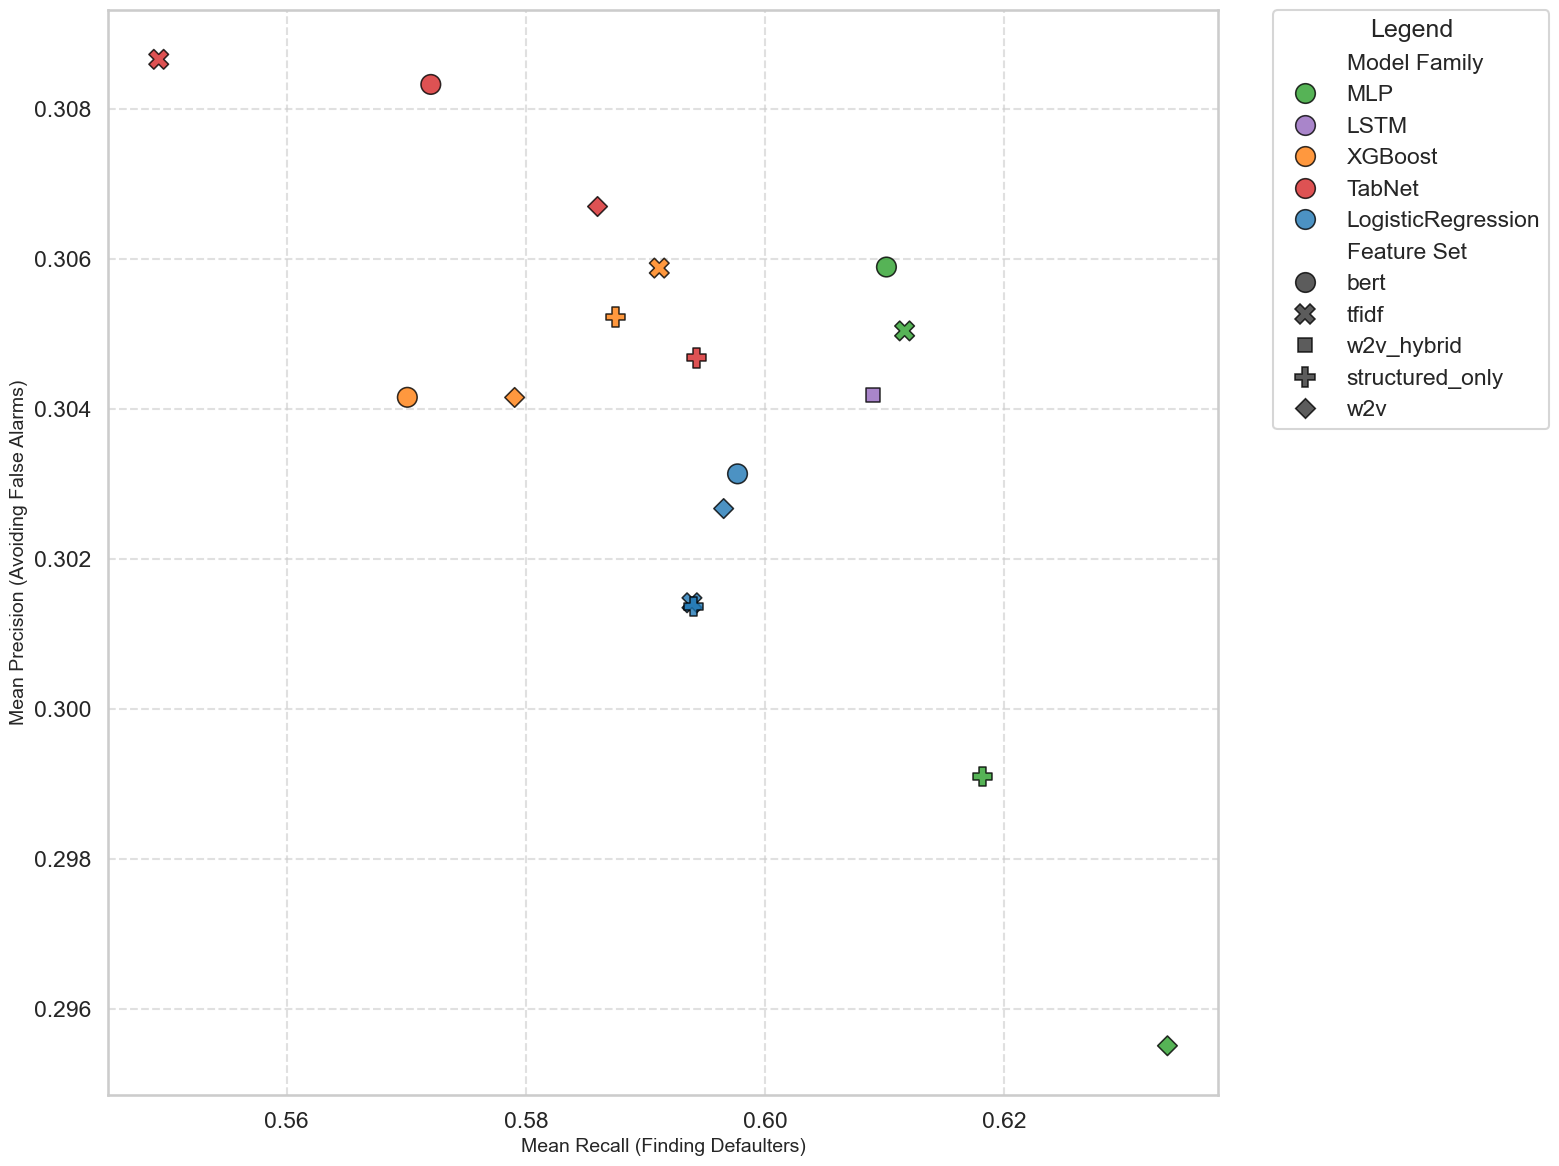


--- Figure 11: F1-Score Sensitivity Analysis ---


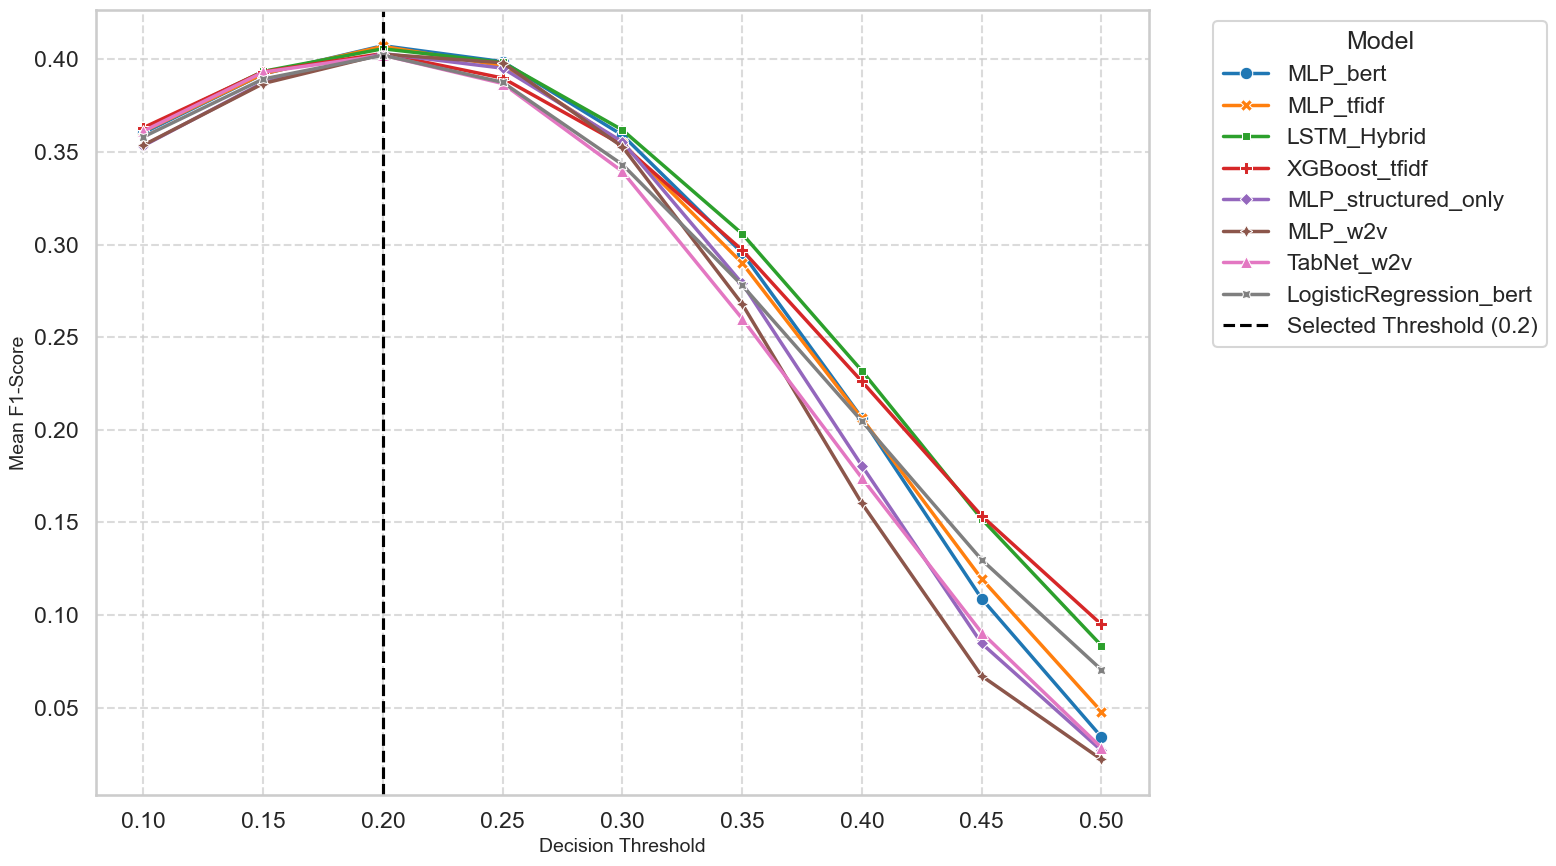


--- Figure 12: Precision-Recall Sensitivity Analysis ---


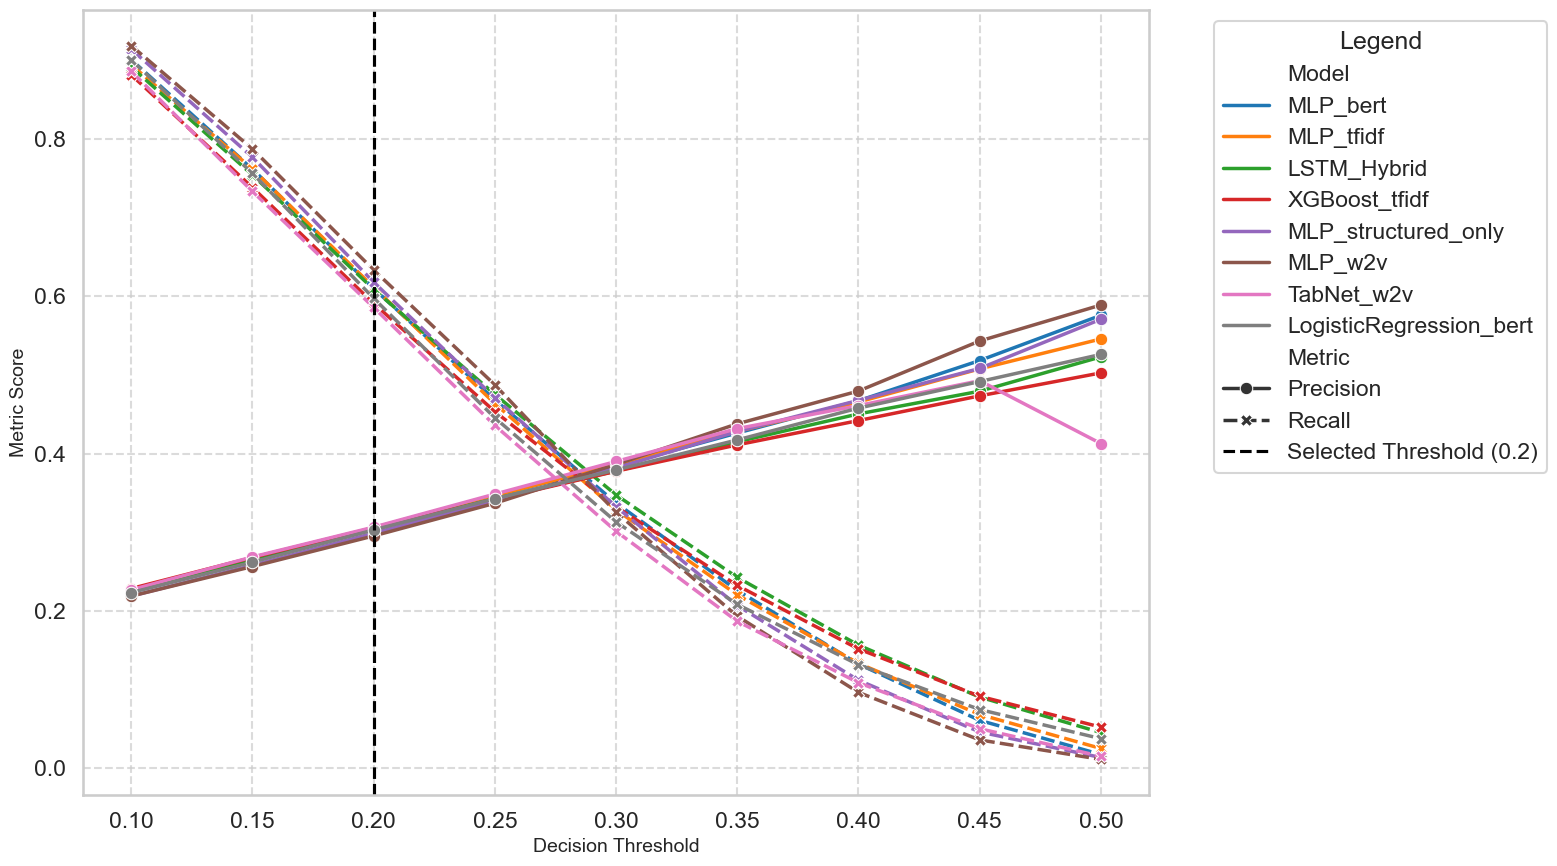


--- Cell 8: Graphs for Analysis complete ---


In [20]:
# =============================================================================
# Cell 8: Graphs for Analysis
# =============================================================================

# Set a consistent colour scheme
sns.set_style("whitegrid")
sns.set_context("talk") 
DISTINCT_PALETTE_4 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

MODEL_FAMILY_PALETTE = {
    "LogisticRegression": "#1f77b4",
    "XGBoost": "#ff7f0e",            
    "MLP": "#2ca02c",            
    "TabNet": "#d62728",  
    "LSTM": "#9467bd"   
}

# Figure 6: F1-Score and AUPRC Uplift from Unstructured Data
print("\n--- Figure 6: F1-Score and AUPRC Uplift from Unstructured Data ---")

model_families = ['LogisticRegression', 'XGBoost', 'MLP', 'TabNet']
uplift_data = []

for family in model_families:
    try:
        # Baseline scores
        baseline_f1 = cv_summary_df.loc[f'{family}_structured_only']['Mean F1-Score']
        baseline_auprc = cv_summary_df.loc[f'{family}_structured_only']['Mean AUPRC']
        
        # Best hybrid scores
        hybrid_models = cv_summary_df[cv_summary_df.index.str.startswith(f'{family}_') & ~cv_summary_df.index.str.contains('structured_only')]
        if not hybrid_models.empty:
            best_hybrid_f1 = hybrid_models['Mean F1-Score'].max()
            best_hybrid_auprc = hybrid_models['Mean AUPRC'].max()
            
            # Append data for F1-Score
            uplift_data.append({'Model Family': family, 'Type': 'Structured Only', 'Metric': 'F1-Score', 'Score': baseline_f1})
            uplift_data.append({'Model Family': family, 'Type': 'Best Hybrid', 'Metric': 'F1-Score', 'Score': best_hybrid_f1})
            # Append data for AUPRC
            uplift_data.append({'Model Family': family, 'Type': 'Structured Only', 'Metric': 'AUPRC', 'Score': baseline_auprc})
            uplift_data.append({'Model Family': family, 'Type': 'Best Hybrid', 'Metric': 'AUPRC', 'Score': best_hybrid_auprc})
    except KeyError:
        print(f"Warning: Could not find models for family {family}. Skipping.")

uplift_df = pd.DataFrame(uplift_data)
uplift_df['Hue Group'] = uplift_df['Metric'] + ' (' + uplift_df['Type'] + ')'
custom_palette = {
    'F1-Score (Structured Only)': '#1f77b4',
    'F1-Score (Best Hybrid)': '#aec7e8',  
    'AUPRC (Structured Only)': '#ff7f0e',
    'AUPRC (Best Hybrid)': '#ffbb78'
}

plt.figure(figsize=(18, 10))
ax = sns.barplot(
    data=uplift_df,
    x='Model Family',
    y='Score',
    hue='Hue Group',
    palette=custom_palette,
    hue_order=['F1-Score (Structured Only)', 'F1-Score (Best Hybrid)', 'AUPRC (Structured Only)', 'AUPRC (Best Hybrid)']
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.xlabel('Model Architecture', fontsize=14)
plt.ylabel('Performance Score', fontsize=14)
min_score = uplift_df['Score'].min() if not uplift_df.empty else 0
plt.ylim(bottom=max(0, min_score - 0.01), top=ax.get_ylim()[1] * 1.08)
plt.legend(title='Metric (Feature Set)', loc='upper right')
plt.tight_layout()
plt.savefig('results/charts/Figure6.png')
plt.show()



# Figure 7: Percentage Uplift in Performance
print("\n--- Figure 7: Percentage Uplift in Performance ---")

pivot_df = uplift_df.pivot_table(index=['Model Family', 'Metric'], columns='Type', values='Score').reset_index()
pivot_df['Uplift (%)'] = ((pivot_df['Best Hybrid'] - pivot_df['Structured Only']) / pivot_df['Structured Only']) * 100
chart_2_palette = {'F1-Score': '#1f77b4', 'AUPRC': '#ff7f0e'} 
plt.figure(figsize=(14, 8))
ax2 = sns.barplot(data=pivot_df, x='Model Family', y='Uplift (%)', hue='Metric', palette=chart_2_palette)

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f%%', padding=3)

plt.xlabel('Model Architecture', fontsize=14)
plt.ylabel('Performance Uplift (%)', fontsize=14)
plt.axhline(0, color='black', lw=0.8)
plt.ylim(top=ax2.get_ylim()[1] * 1.08)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('results/charts/Figure7.png')
plt.show()




# Figure 8: Model Stability
print("\n--- Figure 8: Model Stability (Grouped Boxplot) ---")

f1_scores_per_fold = []
for model_name, fold_results in all_cv_results.items():
    if not fold_results: continue
    for i, result in enumerate(fold_results):
        y_true = result['y_true']
        y_pred_proba = result['y_pred_proba']
        y_pred_class = (y_pred_proba >= 0.2).astype(int)
        f1 = f1_score(y_true, y_pred_class, zero_division=0)
        f1_scores_per_fold.append({'Model': model_name, 'Fold': i+1, 'F1-Score': f1})

f1_df = pd.DataFrame(f1_scores_per_fold)

model_families = ['LogisticRegression', 'XGBoost', 'MLP', 'TabNet']
selected_models_data = []

for family in model_families:
    try:
        structured_model_name = f'{family}_structured_only'
        if structured_model_name in cv_summary_df.index:
            selected_models_data.append({
                'Model': structured_model_name,
                'Model Family': family,
                'Type': 'Structured Only'
            })
        hybrid_models = cv_summary_df[cv_summary_df.index.str.startswith(f'{family}_') & ~cv_summary_df.index.str.contains('structured_only')]
        if not hybrid_models.empty:
            best_hybrid_model_name = hybrid_models['Mean F1-Score'].idxmax()
            selected_models_data.append({
                'Model': best_hybrid_model_name,
                'Model Family': family,
                'Type': 'Best Hybrid'
            })
    except KeyError:
        print(f"Warning: Could not find models for family {family} for stability plot. Skipping.")

selected_models_df = pd.DataFrame(selected_models_data)
plot_data = pd.merge(f1_df, selected_models_df, on='Model')
boxplot_palette = {
    'Structured Only': '#1f77b4',
    'Best Hybrid': '#ff7f0e' 
}

plt.figure(figsize=(18, 10))
sns.boxplot(
    data=plot_data,
    x='Model Family',
    y='F1-Score',
    hue='Type',
    palette=boxplot_palette
)

plt.xlabel('Model Architecture', fontsize=14)
plt.ylabel('F1-Score Distribution Across Folds', fontsize=14)
plt.legend(title='Feature Set', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('results/charts/Figure8.png')
plt.show()



# Figure 9: Performance Trajectory Across Feature Sets
print("\n--- Figure 9: Performance Trajectory Across Feature Sets ---")

plot_data = cv_summary_df[['Mean F1-Score', 'Mean AUPRC']].copy()
plot_data['Model Family'] = plot_data.index.str.split('_').str[0]
plot_data['Feature Set'] = plot_data.index.str.split('_').str[1:].str.join('_')
plot_data = plot_data[plot_data['Model Family'] != 'LSTM']
melted_plot_data = plot_data.melt(
    id_vars=['Model Family', 'Feature Set'],
    var_name='Metric',
    value_name='Score'
)
feature_order = ['structured_only', 'tfidf', 'w2v', 'bert']
melted_plot_data['Feature Set'] = pd.Categorical(melted_plot_data['Feature Set'], categories=feature_order, ordered=True)
fig, axes = plt.subplots(1, 2, figsize=(24, 9), sharey=False)

# Subplot 1: F1-Score
f1_data = melted_plot_data[melted_plot_data['Metric'] == 'Mean F1-Score']
sns.lineplot(
    data=f1_data,
    x='Feature Set',
    y='Score',
    hue='Model Family',
    style='Model Family',
    markers=True,
    dashes=False,
    lw=2.5,
    palette=DISTINCT_PALETTE_4,
    ax=axes[0],
    hue_order=['LogisticRegression', 'XGBoost', 'MLP', 'TabNet']
)
axes[0].set_title('Classification Performance (F1-Score)', fontsize=18, pad=15)
axes[0].set_ylabel('Mean F1-Score', fontsize=14)
axes[0].set_xlabel('Feature Set', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
min_f1 = f1_data['Score'].min()
axes[0].set_ylim(bottom=max(0, min_f1 - 0.005 if not f1_data.empty else 0))
axes[0].legend(title='Model Family', loc='lower right')

# Subplot 2: AUPRC
auprc_data = melted_plot_data[melted_plot_data['Metric'] == 'Mean AUPRC']
sns.lineplot(
    data=auprc_data,
    x='Feature Set',
    y='Score',
    hue='Model Family',
    style='Model Family',
    markers=True,
    dashes=False,
    lw=2.5,
    palette=DISTINCT_PALETTE_4,
    ax=axes[1],
    hue_order=['LogisticRegression', 'XGBoost', 'MLP', 'TabNet']
)
axes[1].set_title('Ranking Power (AUPRC)', fontsize=18, pad=15)
axes[1].set_ylabel('Mean AUPRC', fontsize=14)
axes[1].set_xlabel('Feature Set', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
min_auprc = auprc_data['Score'].min()
axes[1].set_ylim(bottom=max(0, min_auprc - 0.005 if not auprc_data.empty else 0))
axes[1].legend(title='Model Family', loc='lower right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('results/charts/Figure9.png')
plt.show()



# Figure 10: Precision vs. Recall Trade-off for All Models
print("\n--- Figure 10: Precision vs. Recall Trade-off for All Models ---")

plt.figure(figsize=(16, 12))
plot_df = cv_summary_df.copy()
plot_df['Model Family'] = plot_df.index.str.split('_').str[0]
plot_df['Feature Set'] = plot_df.index.str.split('_').str[1:].str.join('_')
plot_df.loc[plot_df.index == 'LSTM_Hybrid', 'Feature Set'] = 'w2v_hybrid'
sns.scatterplot(
    x='Mean Recall',
    y='Mean Precision',
    data=plot_df,
    hue='Model Family',
    style='Feature Set',
    s=200,
    palette=MODEL_FAMILY_PALETTE,
    edgecolor='black',
    alpha=0.8)
plt.xlabel('Mean Recall (Finding Defaulters)', fontsize=14)
plt.ylabel('Mean Precision (Avoiding False Alarms)', fontsize=14)
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('results/charts/Figure10.png')
plt.show()



# Figure 11: F1-Score Sensitivity Analysis
print("\n--- Figure 11: F1-Score Sensitivity Analysis ---")

top_models = cv_summary_df.head(8).index.tolist()
thresholds = np.linspace(0.1, 0.5, 9)
sensitivity_data = []

DISTINCT_PALETTE_8 = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'
]

if not 'sensitivity_df' in locals():
    for model_name in top_models:
        for thresh in thresholds:
            fold_f1s, fold_precisions, fold_recalls = [], [], []
            if model_name in all_cv_results:
                for fold_result in all_cv_results[model_name]:
                    y_true = fold_result['y_true']
                    y_pred_proba = fold_result['y_pred_proba']
                    y_pred_class = (y_pred_proba >= thresh).astype(int)
                    fold_f1s.append(f1_score(y_true, y_pred_class, zero_division=0))
                    fold_precisions.append(precision_score(y_true, y_pred_class, zero_division=0))
                    fold_recalls.append(recall_score(y_true, y_pred_class, zero_division=0))
                sensitivity_data.append({
                    'Model': model_name, 'Threshold': thresh,
                    'F1-Score': np.mean(fold_f1s), 'Precision': np.mean(fold_precisions), 'Recall': np.mean(fold_recalls)
                })
    sensitivity_df = pd.DataFrame(sensitivity_data)
    
plt.figure(figsize=(16, 9))
sns.lineplot(
    data=sensitivity_df, x='Threshold', y='F1-Score', hue='Model', style='Model',
    markers=True, dashes=False, lw=2.5, palette=DISTINCT_PALETTE_8
)
plt.xlabel('Decision Threshold', fontsize=14)
plt.ylabel('Mean F1-Score', fontsize=14)
plt.axvline(x=0.2, color='black', linestyle='--', label='Selected Threshold (0.2)')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('results/charts/Figure11.png')
plt.show()



# Figure 12: Precision-Recall Sensitivity Analysis
print("\n--- Figure 12: Precision-Recall Sensitivity Analysis ---")

pr_melted_df = sensitivity_df.melt(
    id_vars=['Model', 'Threshold'],
    value_vars=['Precision', 'Recall'],
    var_name='Metric',
    value_name='Score')
plt.figure(figsize=(16, 9))
sns.lineplot(
    data=pr_melted_df, x='Threshold', y='Score', hue='Model', style='Metric',
    markers=True, dashes=True, lw=2.5, palette=DISTINCT_PALETTE_8)
plt.xlabel('Decision Threshold', fontsize=14)
plt.ylabel('Metric Score', fontsize=14)
plt.axvline(x=0.2, color='black', linestyle='--', label='Selected Threshold (0.2)')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('results/charts/Figure12.png')
plt.show()

print("\n--- Cell 8: Graphs for Analysis complete ---")


--- Figure 13: F1-Score at different training sizes ---
Full Word2Vec feature sets created.
Full BERT feature sets created.

Processing model: MLP_bert...
  - Training with 10% of the data...
  - Training with 25% of the data...
  - Training with 50% of the data...
  - Training with 75% of the data...
  - Training with 100% of the data...

Processing model: MLP_tfidf...
  - Training with 10% of the data...
  - Training with 25% of the data...
  - Training with 50% of the data...
  - Training with 75% of the data...
  - Training with 100% of the data...

Processing model: LSTM_Hybrid...
  - Training with 10% of the data...
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step
  - Training with 25% of the data...
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step
  - Training with 50% of the data...
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step
  - Training with 75% of the data...
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step
  - Training with 100% of the data...
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/

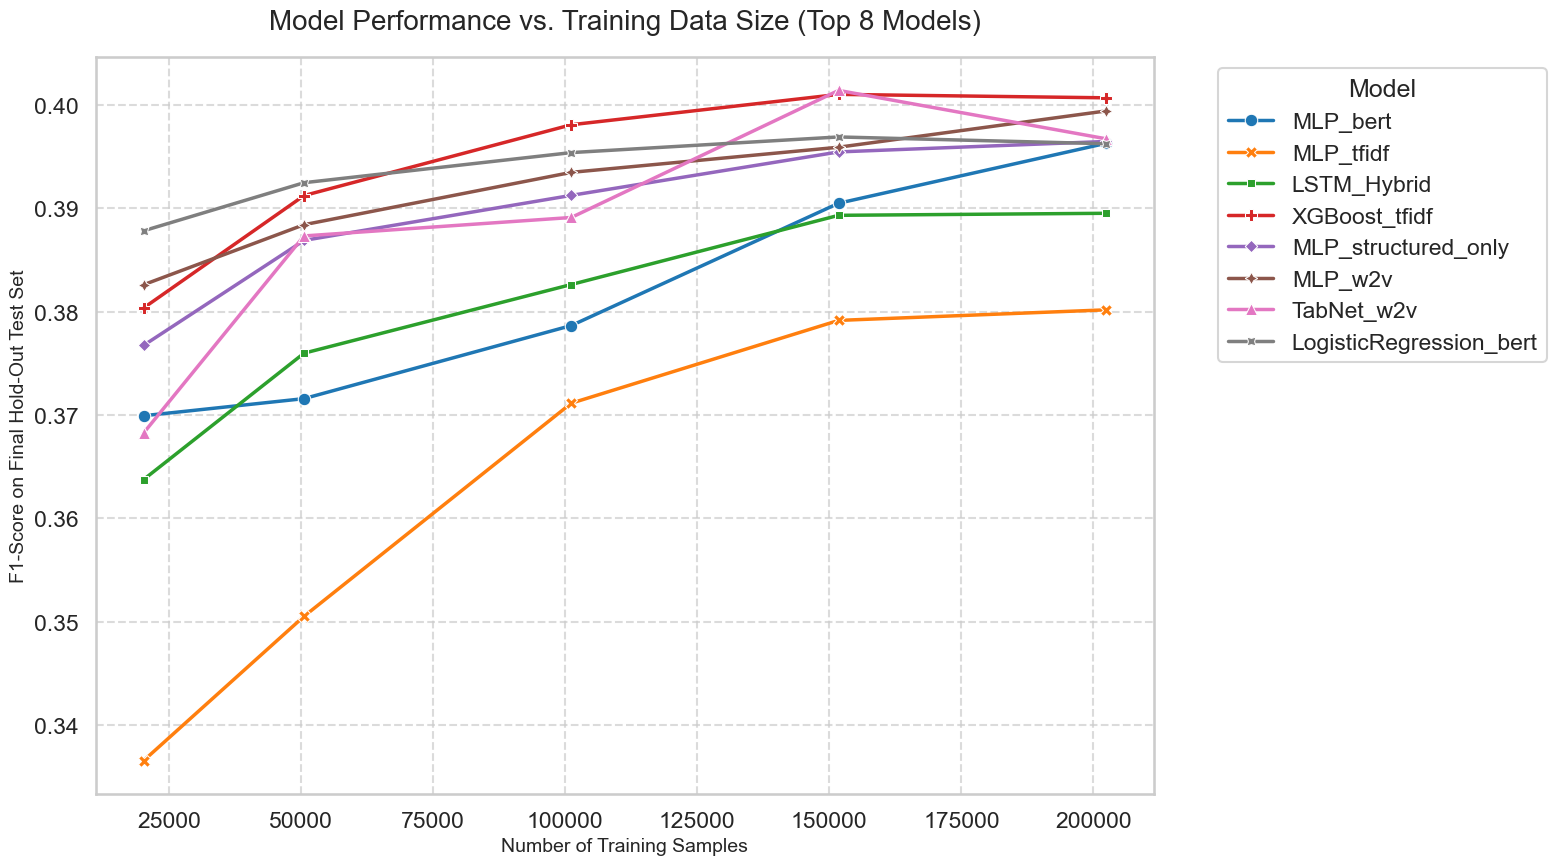


--- Cell 9: Sensitivity Analysis: Data size complete---


In [9]:
# =============================================================================
# Cell 9: Sensitivity Analysis: Data size
# =============================================================================

print("\n--- Figure 25: F1-Score at different training sizes ---")
# Figure 25: F1-Score at different training sizes

# Structured Data
X_train_full_struct_proc = preprocessor_structured.fit_transform(X_train_full)
X_test_final_struct_proc = preprocessor_structured.transform(X_test_final)


# TF-IDF
preprocessor_tfidf_full = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), structured_numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), structured_categorical_features),
        ('tfidf', TfidfVectorizer(max_features=1000), 'text_data')
    ],
    remainder='drop'
)
X_train_full_tfidf = preprocessor_tfidf_full.fit_transform(X_train_full)
X_test_final_tfidf = preprocessor_tfidf_full.transform(X_test_final)

# Word2Vec
tokenized_text_full = [text.split() for text in X_train_full['text_data']]
w2v_model_full = Word2Vec(sentences=tokenized_text_full, vector_size=100, window=5, min_count=2, workers=4)
X_train_full_w2v_text = np.array([document_vector(text, w2v_model_full) for text in X_train_full['text_data']])
X_test_final_w2v_text = np.array([document_vector(text, w2v_model_full) for text in X_test_final['text_data']])
X_train_full_w2v = np.hstack([X_train_full_struct_proc, X_train_full_w2v_text])
X_test_final_w2v = np.hstack([X_test_final_struct_proc, X_test_final_w2v_text])
print("Full Word2Vec feature sets created.")

# BERT
X_train_full_bert = np.hstack([X_train_full_struct_proc, X_train_full_bert_text])
X_test_final_bert_text = bert_model.encode(X_test_final['text_data'].tolist(), device='cpu')
X_test_final_bert = np.hstack([X_test_final_struct_proc, X_test_final_bert_text])
print("Full BERT feature sets created.")

all_X_train_fs = {
    'structured_only': X_train_full_struct_proc, 'tfidf': X_train_full_tfidf,
    'w2v': X_train_full_w2v, 'bert': X_train_full_bert
}
all_X_test_fs = {
    'structured_only': X_test_final_struct_proc, 'tfidf': X_test_final_tfidf,
    'w2v': X_test_final_w2v, 'bert': X_test_final_bert
}

top_8_models = cv_summary_df.head(8).index.tolist()

training_fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
learning_curve_data = []
OPTIMAL_THRESHOLD = 0.2

for model_name in top_8_models:
    print(f"\nProcessing model: {model_name}...")
    
    if "LSTM" in model_name:
        fs_name = "w2v"
        model_type = "LSTM_Hybrid"
    else:
        model_type, fs_name = model_name.split('_', 1)
        
    X_train_fs = all_X_train_fs[fs_name]
    X_test_fs = all_X_test_fs[fs_name]
    model_obj = models_to_train[model_type]
    
    for fraction in training_fractions:
        print(f"  - Training with {int(fraction*100)}% of the data...")
        
        if fraction == 1.0:
            X_train_subset, y_train_subset = X_train_fs, y_train_full
        else:
            X_train_subset, _, y_train_subset, _ = train_test_split(
                X_train_fs, y_train_full, train_size=fraction,
                random_state=42, stratify=y_train_full
            )
        if model_type in ['LogisticRegression', 'XGBoost']:
            model_obj.fit(X_train_subset, y_train_subset)
            y_pred_proba = model_obj.predict_proba(X_test_fs)[:, 1]
        elif model_type == 'MLP':
            mlp_instance = build_mlp((X_train_subset.shape[1],))
            mlp_instance.fit(X_train_subset, y_train_subset, epochs=30, batch_size=256, verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=5)])
            y_pred_proba = mlp_instance.predict(X_test_fs, verbose=0).flatten()
        elif model_type == 'TabNet':
            X_train_dense = X_train_subset.toarray() if hasattr(X_train_subset, 'toarray') else X_train_subset
            X_test_dense = X_test_fs.toarray() if hasattr(X_test_fs, 'toarray') else X_test_fs
            tabnet_instance = TabNetClassifier(optimizer_params=dict(lr=2e-2), verbose=0)
            tabnet_instance.fit(X_train_dense, y_train_subset.to_numpy(), eval_set=[(X_test_dense, y_test_final.to_numpy())], patience=10, max_epochs=50)
            y_pred_proba = tabnet_instance.predict_proba(X_test_dense)[:, 1]
        elif model_type == 'LSTM_Hybrid':
            X_train_struct_subset = X_train_subset[:, :X_train_full_struct_proc.shape[1]]
            X_train_text_subset = X_train_subset[:, X_train_full_struct_proc.shape[1]:].reshape(X_train_subset.shape[0], 1, 100)
            
            X_test_struct = X_test_fs[:, :X_test_final_struct_proc.shape[1]]
            X_test_text = X_test_fs[:, X_test_final_struct_proc.shape[1]:].reshape(X_test_fs.shape[0], 1, 100)

            lstm_instance = build_lstm_hybrid(X_train_struct_subset.shape[1:], X_train_text_subset.shape[1:])
            lstm_instance.fit([X_train_struct_subset, X_train_text_subset], y_train_subset, epochs=30, batch_size=256, verbose=0, callbacks=[EarlyStopping(monitor='loss', patience=5)])
            y_pred_proba = lstm_instance.predict([X_test_struct, X_test_text]).flatten()

        y_pred_class = (y_pred_proba >= OPTIMAL_THRESHOLD).astype(int)
        f1 = f1_score(y_test_final, y_pred_class, zero_division=0)
        
        learning_curve_data.append({
            'Model': model_name,
            'Training Size': X_train_subset.shape[0],
            'F1-Score': f1
        })

learning_curve_df = pd.DataFrame(learning_curve_data)

DISTINCT_PALETTE_8 = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'
]
plt.figure(figsize=(16, 9))
sns.lineplot(
    data=learning_curve_df,
    x='Training Size',
    y='F1-Score',
    hue='Model',
    style='Model',
    markers=True,
    dashes=False,
    lw=2.5,
    palette=DISTINCT_PALETTE_8,
    hue_order=top_8_models
)
plt.title('Model Performance vs. Training Data Size (Top 8 Models)', fontsize=20, pad=20)
plt.xlabel('Number of Training Samples', fontsize=14)
plt.ylabel('F1-Score on Final Hold-Out Test Set', fontsize=14)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('results/charts/Figure25.png')
plt.show()

print("\n--- Cell 9: Sensitivity Analysis: Data size complete---")

Batches:   0%|          | 0/1582 [00:00<?, ?it/s]

Epoch 1/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.6478 - loss: 0.4574 - val_AUC: 0.7041 - val_loss: 0.4291
Epoch 2/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.6993 - loss: 0.4330 - val_AUC: 0.7081 - val_loss: 0.4274
Epoch 3/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7040 - loss: 0.4315 - val_AUC: 0.7108 - val_loss: 0.4265
Epoch 4/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7048 - loss: 0.4308 - val_AUC: 0.7138 - val_loss: 0.4249
Epoch 5/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7125 - loss: 0.4287 - val_AUC: 0.7152 - val_loss: 0.4243
Epoch 6/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7164 - loss: 0.4270 - val_AUC: 0.7147 - val_loss: 0.4244
Epoch 7/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7156 - loss: 0.4264 - val_AUC: 0.7143 - val_loss: 0.4245
Epoch 8/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7201 - loss: 0.4217 - val_AUC: 0.7154 - val_loss: 0.4249
Epoch 9/30
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AU

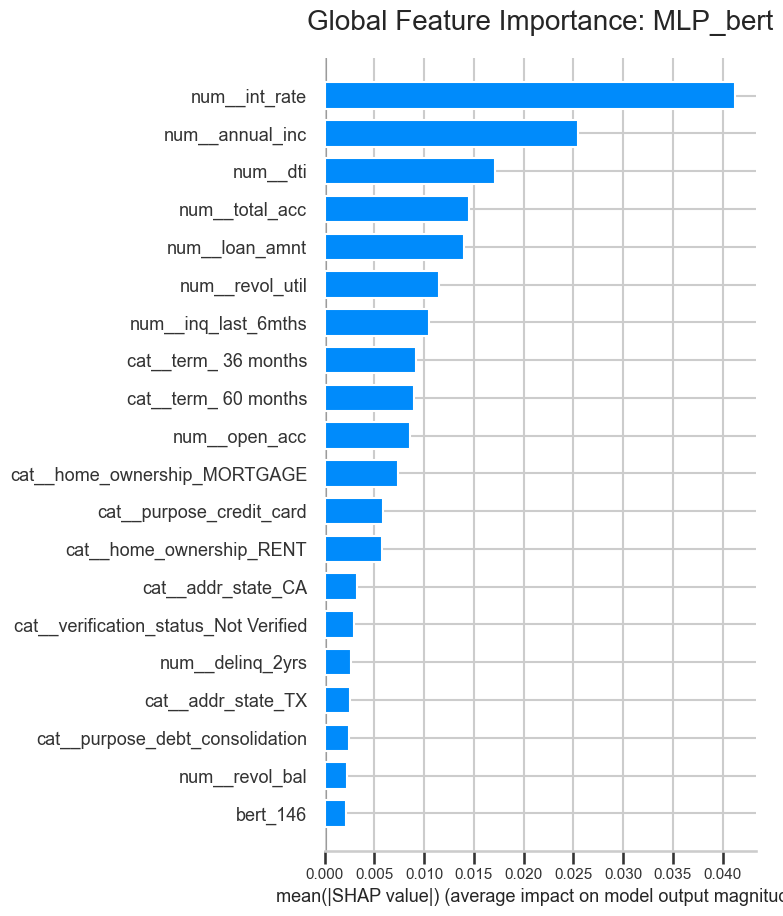


--- Figure 14: SHAP Plot ---


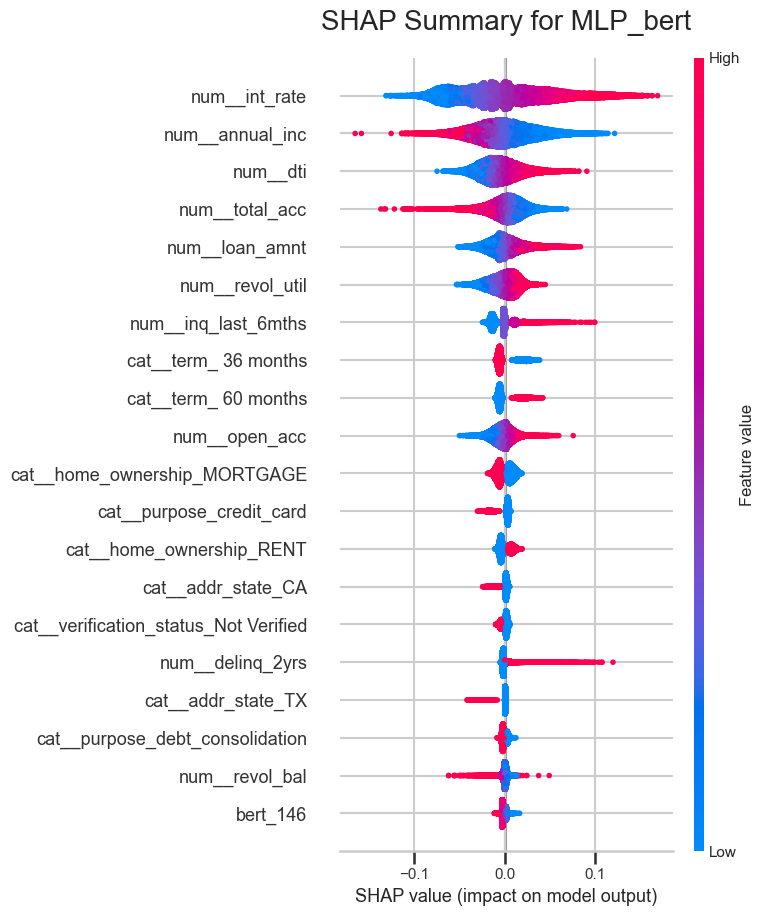


--- Figure 15: Violin Plot of Key Features by Classification Outcome ---

--- Final Evaluation Metrics on Test Set ---
Accuracy:  0.6753
Precision: 0.3007
Recall:    0.6147
F1-Score:  0.4038
AUC:       0.7099
AUPRC:     0.3429

Total Misclassified Loans: 16,426
  - False Negatives (Predicted Paid, but Defaulted): 3,487
  - False Positives (Predicted Default, but Paid): 12,939


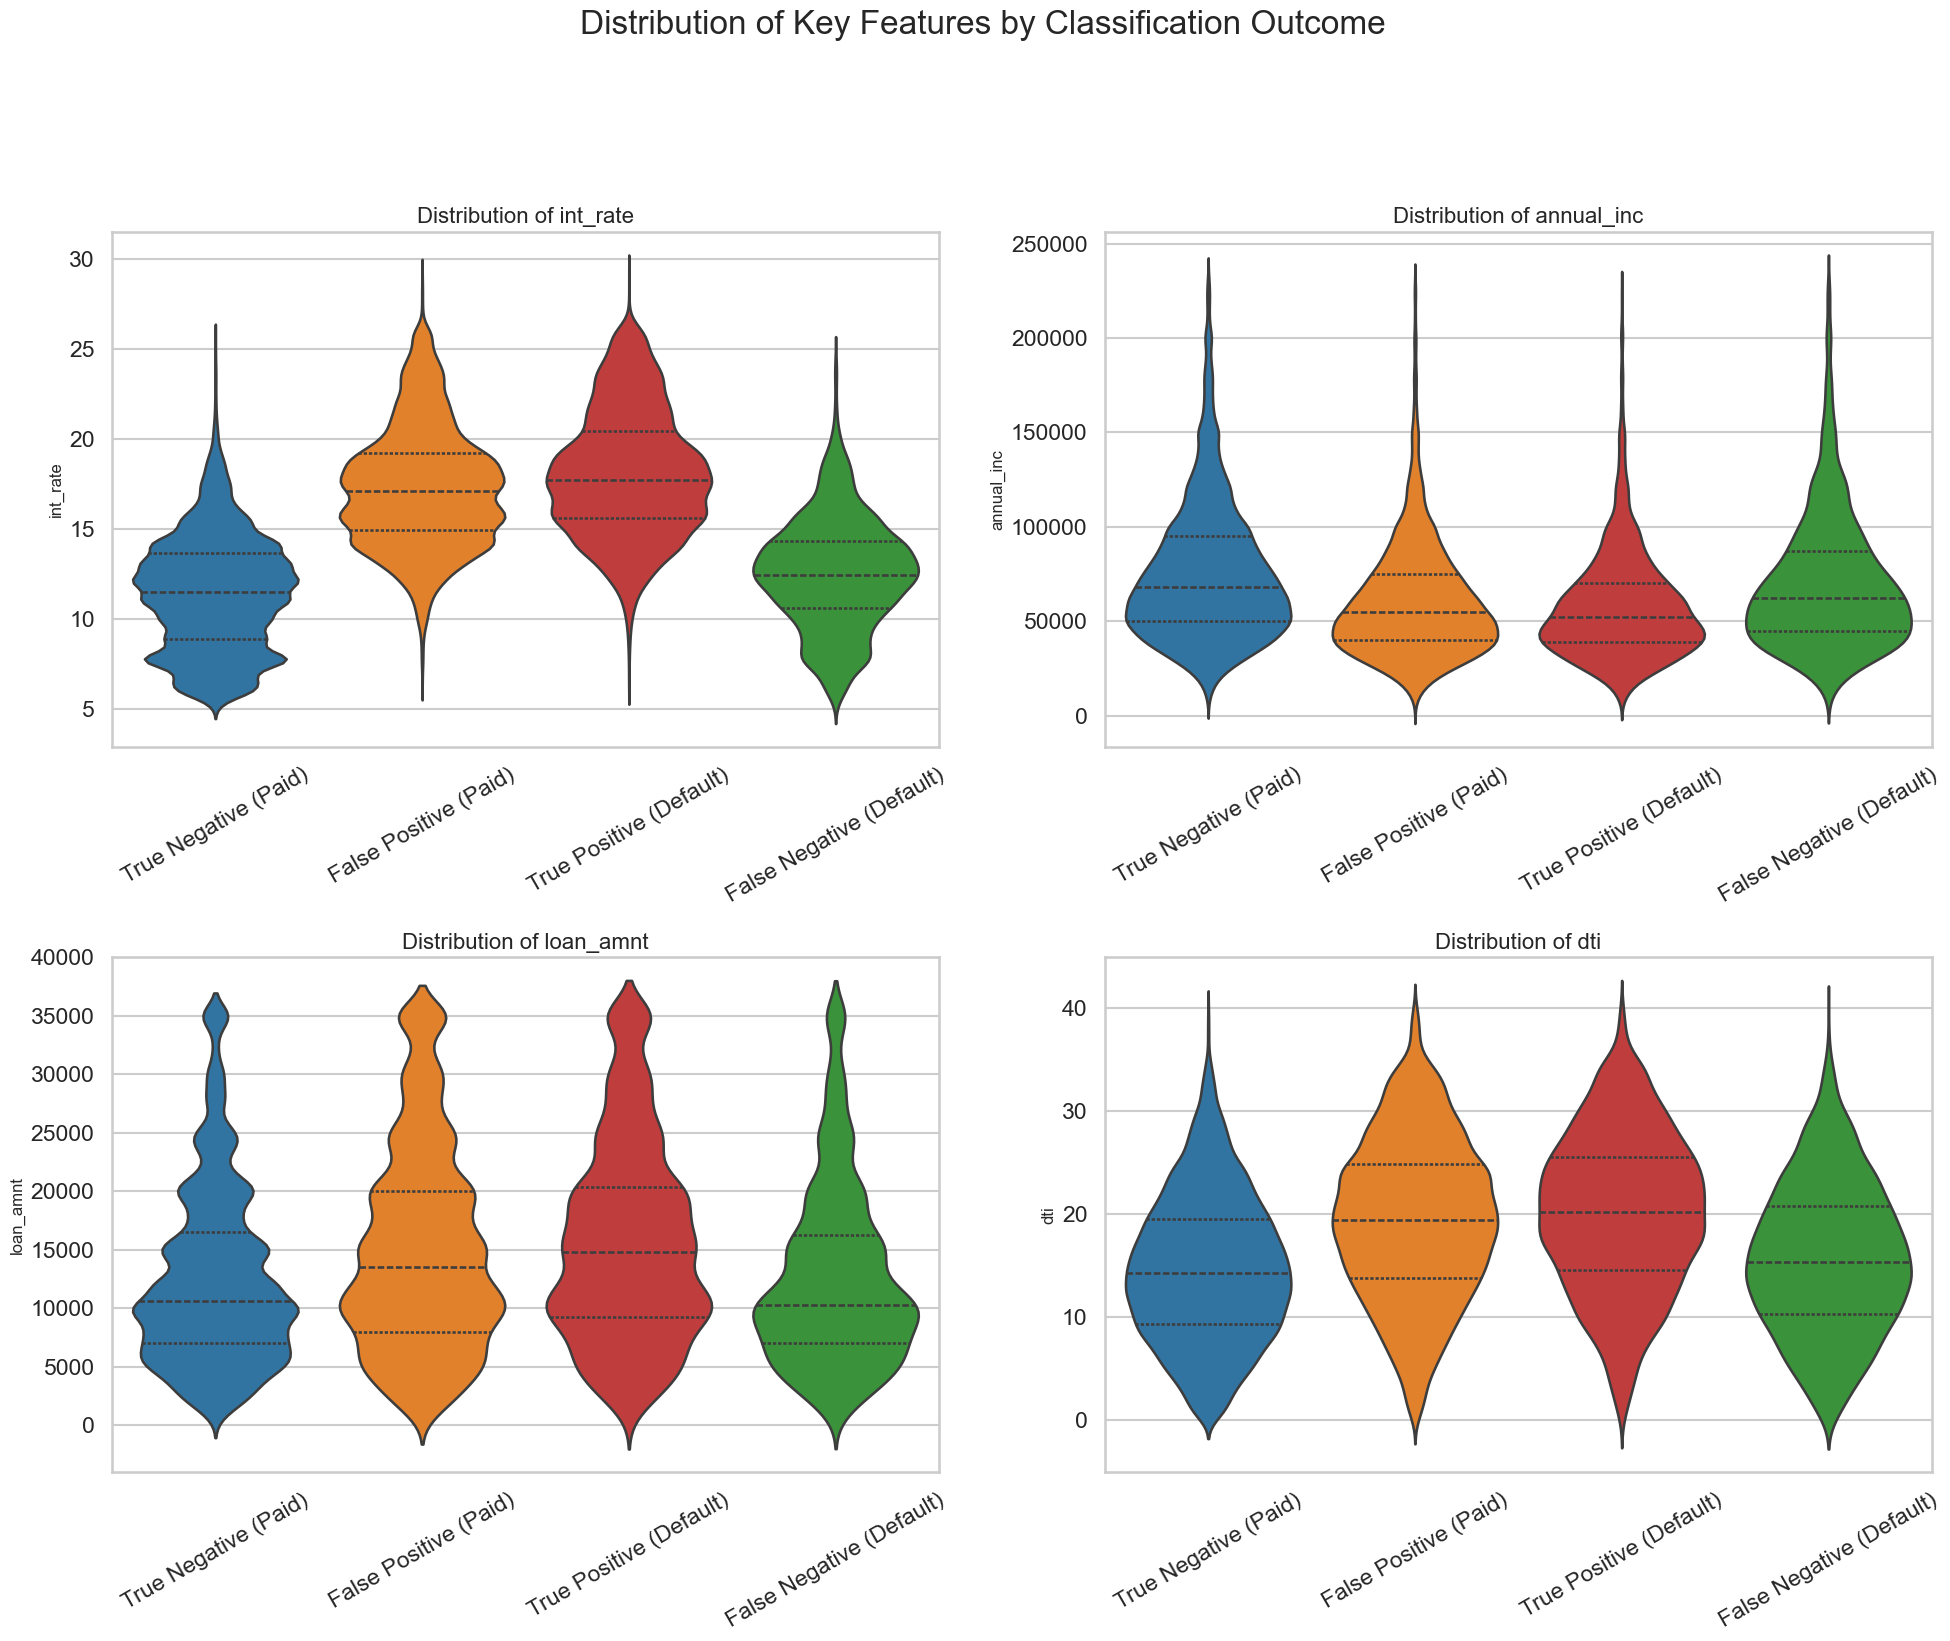

In [23]:
# =============================================================================
# Cell 10: Champion Model Analysis
# =============================================================================

sns.set_style("whitegrid")
sns.set_context("talk")

CHAMPION_MODEL_NAME = 'MLP_bert' 

warnings.filterwarnings('ignore', message="The structure of `inputs` doesn't match the expected structure.")
warnings.filterwarnings('ignore', message="Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported.")


preprocessor_structured.fit(X_train_full)
X_train_full_struct = preprocessor_structured.transform(X_train_full)
X_test_final_struct = preprocessor_structured.transform(X_test_final)

X_test_final_bert_text = bert_model.encode(X_test_final['text_data'].tolist(), show_progress_bar=True, device='cpu')

X_train_final_fs = np.hstack([X_train_full_struct, X_train_full_bert_text])
X_test_final_fs = np.hstack([X_test_final_struct, X_test_final_bert_text])

# Build and train the final model
final_model = build_mlp((X_train_final_fs.shape[1],))
final_model.fit(
    X_train_final_fs, y_train_full,
    epochs=30,
    batch_size=256,
    verbose=1,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

background_data = X_train_final_fs[np.random.choice(X_train_final_fs.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(final_model, background_data)
raw_shap_values = explainer.shap_values(X_test_final_fs)

if isinstance(raw_shap_values, list):
    shap_values = raw_shap_values[0]
else:
    shap_values = raw_shap_values

if shap_values.ndim == 3 and shap_values.shape[2] == 1:
    shap_values = shap_values.squeeze(-1)

try:
    structured_feature_names = preprocessor_structured.get_feature_names_out()
    text_feature_names = [f'bert_{i}' for i in range(X_train_full_bert_text.shape[1])]
    all_feature_names = list(structured_feature_names) + text_feature_names
except Exception as e:
    print(f"Could not generate feature names, using generic names. Error: {e}")
    all_feature_names = [f'feature_{i}' for i in range(X_test_final_fs.shape[1])]

print("\n--- Figure 13: Feature importance plot ---")
# Figure 13: Feature importance plot
shap.summary_plot(
    shap_values,
    features=X_test_final_fs,
    feature_names=all_feature_names,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title(f'Global Feature Importance: {CHAMPION_MODEL_NAME}', fontsize=20, pad=20)
plt.tight_layout()
plt.savefig(f'results/charts/Figure13.png')
plt.show()

print("\n--- Figure 14: SHAP Plot ---")
# Figure 14: SHAP Plot
shap.summary_plot(
    shap_values,
    features=X_test_final_fs,
    feature_names=all_feature_names,
    max_display=20,
    show=False
)
fig = plt.gcf()
plt.title(f'SHAP Summary for {CHAMPION_MODEL_NAME}', fontsize=20, pad=20)
plt.tight_layout()
fig.savefig(f'results/charts/Figure14.png')
plt.show()



print("\n--- Figure 15: Violin Plot of Key Features by Classification Outcome ---")
# Figure 15: Violin Plot of Key Features by Classification Outcome

y_pred_proba_final = final_model.predict(X_test_final_fs, verbose=0).flatten()
y_pred_class_final = (y_pred_proba_final >= OPTIMAL_THRESHOLD).astype(int)

print("\n--- Final Evaluation Metrics on Test Set ---")
print(f"Accuracy:  {accuracy_score(y_test_final, y_pred_class_final):.4f}")
print(f"Precision: {precision_score(y_test_final, y_pred_class_final):.4f}")
print(f"Recall:    {recall_score(y_test_final, y_pred_class_final):.4f}")
print(f"F1-Score:  {f1_score(y_test_final, y_pred_class_final):.4f}")
print(f"AUC:       {roc_auc_score(y_test_final, y_pred_proba_final):.4f}")
print(f"AUPRC:     {average_precision_score(y_test_final, y_pred_proba_final):.4f}")

results_df = X_test_final.copy()
results_df['true_label'] = y_test_final
results_df['predicted_label'] = y_pred_class_final

false_negatives_df = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)]
false_positives_df = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)]

print(f"\nTotal Misclassified Loans: {len(false_negatives_df) + len(false_positives_df):,}")
print(f"  - False Negatives (Predicted Paid, but Defaulted): {len(false_negatives_df):,}")
print(f"  - False Positives (Predicted Default, but Paid): {len(false_positives_df):,}")

if 'classification_type' not in results_df.columns:
    def get_classification_type(row):
        if row['true_label'] == 1 and row['predicted_label'] == 1:
            return 'True Positive (Default)'
        elif row['true_label'] == 0 and row['predicted_label'] == 0:
            return 'True Negative (Paid)'
        elif row['true_label'] == 0 and row['predicted_label'] == 1:
            return 'False Positive (Paid)'
        elif row['true_label'] == 1 and row['predicted_label'] == 0:
            return 'False Negative (Default)'
        return 'Other'
    results_df['classification_type'] = results_df.apply(get_classification_type, axis=1)

features_to_plot = ['int_rate', 'annual_inc', 'loan_amnt', 'dti']
plot_order = ['True Negative (Paid)', 'False Positive (Paid)', 'True Positive (Default)', 'False Negative (Default)']

DISTINCT_PALETTE_4 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
custom_palette = {
    'True Negative (Paid)': DISTINCT_PALETTE_4[0],     
    'False Positive (Paid)': DISTINCT_PALETTE_4[1],    
    'False Negative (Default)': DISTINCT_PALETTE_4[2], 
    'True Positive (Default)': DISTINCT_PALETTE_4[3]  
}

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Distribution of Key Features by Classification Outcome', fontsize=24, y=1.03)
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    plot_data = results_df
    if feature == 'annual_inc':
        q99 = results_df['annual_inc'].quantile(0.99)
        plot_data = results_df[results_df['annual_inc'] < q99]
    sns.violinplot(
        x='classification_type',
        y=feature,
        data=plot_data,
        order=plot_order,
        palette=custom_palette,
        ax=axes[i],
        hue='classification_type',
        legend=False,
        inner='quartile'
    )
    axes[i].set_title(f'Distribution of {feature}', fontsize=16)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(feature, fontsize=12)
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('results/charts/Figure15.png')
plt.show()